In [16]:
# Data
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import impl.layer as l

# Dataset preparation and pre-processing
mnist = input_data.read_data_sets('data/MNIST_data/', one_hot=False)

X_train, y_train = mnist.train.images, mnist.train.labels
X_val, y_val = mnist.validation.images, mnist.validation.labels
X_test, y_test = mnist.test.images, mnist.test.labels
y_test.shape, y_val.shape, y_train.shape

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


((10000,), (5000,), (55000,))

In [17]:
def selu_forward(X):
    alpha = 1.6732632423543772848170429916717
    scale = 1.0507009873554804934193349852946
    out = scale * np.where(X>=0.0, X, alpha * (np.exp(X)-1))
    cache = X
    return out, cache

def selu_backward(dout, cache):
    alpha = 1.6732632423543772848170429916717
    scale = 1.0507009873554804934193349852946
    X = cache
    dX_pos = dout.copy()
    dX_pos[X<0] = 0
    dX_neg = dout.copy()
    dX_neg[X>0] = 0
    dX = scale * np.where(X>=0.0, dX_pos, dX_neg * alpha * np.exp(X))
    return dX

# Pre-processing
def prepro(X_train, X_val, X_test):
    mean = np.mean(X_train)
    # scale = 255. - mean # std or sqrt(var), 255 == 2**8 or 8 bit grayscale
    # return (X_train - mean)/ scale, (X_val - mean)/ scale, (X_test - mean) / scale
    return X_train - mean, X_val - mean, X_test - mean

X_train, X_val, X_test = prepro(X_train, X_val, X_test)

In [18]:
# Model
import impl.layer as l # or from impl.layer import *
from impl.loss import * # import all functions from impl.loss file # import impl.loss as loss_func
from sklearn.utils import shuffle as skshuffle

class FFNN:

    def __init__(self, D, C, H, L):
        # self.mode = 'classification'
        self.L = L # number of layers or depth
        self.losses = {'train':[], 'smooth train':[], 'valid':[], 'valid_acc':[]}
        
        # The adaptive/learnable/updatable random feedforward
        self.model = []
        self.W_fixed = []
        low, high = -1, 1
        
        # Input layer
        #         m = dict(W=np.random.randn(D, H) / np.sqrt(D / 2.),
        #                  b=np.zeros((1, H)))
        m = dict(W=np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.),
                 b=np.zeros((1, H)))
        self.model.append(m)
        # Fixed feedback weight
        #         m = np.random.randn(D, H) / np.sqrt(D / 2.)
        m = np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.)
        self.W_fixed.append(m)

        # Hidden layers
        #         m = dict(W=np.random.randn(H, H) / np.sqrt(H / 2.),
        #                  b=np.zeros((1, H)))
        m_L = []
        for _ in range(L):
            m = dict(W=np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.),
                     b=np.zeros((1, H)))
            m_L.append(m)
        self.model.append(m_L)
        # Fixed feedback weight
        #         m = np.random.randn(H, H) / np.sqrt(H / 2.)
        m_L = []
        for _ in range(L):
            m = np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.)
            m_L.append(m)
        self.W_fixed.append(m_L)
        
        # Output layer
        #         m = dict(W=np.random.randn(H, C) / np.sqrt(H / 2.),
        #                  b=np.zeros((1, C)))
        m = dict(W=np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.),
                 b=np.zeros((1, C)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.)
        #         m = np.random.randn(H, C) / np.sqrt(H / 2.)
        self.W_fixed.append(m)
        
    def fc_forward(self, X, W, b):
        out = (X @ W) + b
        cache = (W, X)
        return out, cache

    def fc_backward(self, dout, cache, W_fixed):
        W, X = cache

        dW = X.T @ dout
        db = np.sum(dout, axis=0).reshape(1, -1) # db_1xn
        # dX = dout @ W.T # Backprop
        dX = dout @ W_fixed.T # fb alignment

        return dX, dW, db

    def train_forward(self, X):
        caches = []
        
        # Input layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[0]['W'], b=self.model[0]['b']) # X_1xD, y_1xc
        y, nl_cache = selu_forward(X=y)
        X = y.copy() # pass the previous output to the next layer
        caches.append((fc_cache, nl_cache)) # caches[0]
        
        # Hidden layers
        fc_caches, nl_caches = [], []
        for layer in range(self.L):
            y, fc_cache = self.fc_forward(X=X, W=self.model[1][layer]['W'], b=self.model[1][layer]['b'])
            y, nl_cache = selu_forward(X=y)
            X = y.copy() # pass to next layer
            fc_caches.append(fc_cache)
            nl_caches.append(nl_cache)
        caches.append((fc_caches, nl_caches)) # caches[1]
        
        # Output layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[2]['W'], b=self.model[2]['b'])
        caches.append(fc_cache) # caches[2]

        return y, caches

    def loss_function(self, y, y_train):
        
        loss = cross_entropy(y, y_train) # softmax is included
        dy = dcross_entropy(y, y_train) # dsoftmax is included
        
        return loss, dy
    
    def train_backward(self, dy, caches):
        grads = []

        # Input layer
        grads.append({key: np.zeros_like(val) for key, val in self.model[0].items()})
        
        # Hidden layer
        grad = []
        for layer in range(self.L):
            grad.append({key: np.zeros_like(val) for key, val in self.model[1][layer].items()})
        grads.append(grad)

        # Outout layer
        grads.append({key: np.zeros_like(val) for key, val in self.model[2].items()})

        # Output layer
        fc_cache = caches[2]
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[2])
        dy = dX.copy() # pass it to the previous layer
        grads[2]['W'] = dW
        grads[2]['b'] = db

        # Hidden layer
        fc_caches, nl_caches = caches[1]
        for layer in reversed(range(self.L)):
            dy = selu_backward(dout=dy, cache=nl_caches[layer])
            dX, dW, db = self.fc_backward(dout=dy, cache=fc_caches[layer], W_fixed=self.W_fixed[1][layer])
            dy = dX.copy()
            grads[1][layer]['W'] = dW
            grads[1][layer]['b'] = db
        
        # Input layer
        fc_cache, nl_cache = caches[0]
        dy = selu_backward(dout=dy, cache=nl_cache)
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[0])
        grads[0]['W'] = dW
        grads[0]['b'] = db

        return dX, grads
    
    def test(self, X):
        y_logit, _ = self.train_forward(X)
        
        # if self.mode == 'classification':
        y_prob = l.softmax(y_logit) # for accuracy== acc
        y_pred = np.argmax(y_prob, axis=1) # for loss==err
        
        return y_pred, y_logit
        
    def get_minibatch(self, X, y, minibatch_size, shuffle):
        minibatches = []

        if shuffle:
            X, y = skshuffle(X, y)

        for i in range(0, X.shape[0], minibatch_size):
            X_mini = X[i:i + minibatch_size]
            y_mini = y[i:i + minibatch_size]
            minibatches.append((X_mini, y_mini))

        return minibatches

    def adam(self, train_set, val_set, alpha, mb_size, n_iter, print_after):
        X_train, y_train = train_set
        X_val, y_val = val_set

        # Momentums
        M, R = [], []

        # Input layer momentums
        M.append({key: np.zeros_like(val) for key, val in self.model[0].items()})
        R.append({key: np.zeros_like(val) for key, val in self.model[0].items()})

        # Hidden layers momentum
        M_, R_ = [], []
        for layer in range(self.L):
            M_.append({key: np.zeros_like(val) for key, val in self.model[1][layer].items()})
            R_.append({key: np.zeros_like(val) for key, val in self.model[1][layer].items()})
        M.append(M_)
        R.append(R_)

        # Output layer momentums
        M.append({key: np.zeros_like(val) for key, val in self.model[2].items()})
        R.append({key: np.zeros_like(val) for key, val in self.model[2].items()})
 
        # Learning decay
        beta1 = .9
        beta2 = .99
        smooth_train = 1.

        # Epochs
        for iter in range(1, n_iter + 1):

            # Minibatches
            #         """
            #         Single training step over minibatch: forward, loss, backprop
            #         """
            # Shuffle for each epochs/ stochasticity/ randomly choosing
            #             for idx in range(len(minibatches)):
            #             for _ in range(10):
            # Shuffle in every iteration
            # The dataset is static and non-sequentiol: no time-dependency or temporal pattern
            minibatches = self.get_minibatch(X_train, y_train, mb_size, shuffle=True)
            idx = np.random.randint(0, len(minibatches))
            X_mini, y_mini = minibatches[idx]
            
            # Train the model
            y, caches = self.train_forward(X_mini)
            loss, dy = self.loss_function(y, y_mini)
            _, grads = self.train_backward(dy, caches)
            self.losses['train'].append(loss)
            smooth_train = (0.999 * smooth_train) + (0.001 * loss)
            self.losses['smooth train'].append(smooth_train)
            
            # Update the model for input layer
            for key in grads[0].keys():
                self.model[0][key] -= alpha * grads[0][key]
                # M[0][key] = l.exp_running_avg(M[0][key], grads[0][key], beta1)
                # R[0][key] = l.exp_running_avg(R[0][key], grads[0][key]**2, beta2)
                # m_k_hat = M[0][key] / (1. - (beta1**(iter)))
                # r_k_hat = R[0][key] / (1. - (beta2**(iter)))
                # self.model[0][key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + l.eps)

            # Update the model for the hidden layers
            for layer in range(self.L):
                for key in grads[1][layer].keys():
                    self.model[1][layer][key] -= alpha * grads[1][layer][key]
                    # M[1][layer][key] = l.exp_running_avg(M[1][layer][key], grads[1][layer][key], beta1)
                    # R[1][layer][key] = l.exp_running_avg(R[1][layer][key], grads[1][layer][key]**2, beta2)
                    # m_k_hat = M[1][layer][key] / (1. - (beta1**(iter)))
                    # r_k_hat = R[1][layer][key] / (1. - (beta2**(iter)))
                    # self.model[1][layer][key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + l.eps)


            # Update the model for output layer
            for key in grads[2].keys():
                self.model[2][key] -= alpha * grads[2][key]
                # M[2][key] = l.exp_running_avg(M[2][key], grads[2][key], beta1)
                # R[2][key] = l.exp_running_avg(R[2][key], grads[2][key]**2, beta2)
                # m_k_hat = M[2][key] / (1. - (beta1**(iter)))
                # r_k_hat = R[2][key] / (1. - (beta2**(iter)))
                # self.model[2][key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + l.eps)

            # Validate the updated model
            y_pred, y_logit = self.test(X_val)
            valid_loss, _ = self.loss_function(y_logit, y_val) # softmax is included in entropy loss function
            self.losses['valid'].append(valid_loss)
            valid_acc = np.mean(y_pred == y_val)
            self.losses['valid_acc'].append(valid_acc)
            
            # Print the model info: loss & accuracy or err & acc
            if iter % print_after == 0:
                print('Iter-{} train loss: {:.4f} valid loss: {:.4f}, valid accuracy: {:.4f}'.format(
                    iter, loss, valid_loss, valid_acc))

        # Test the final model
        y_pred, y_logit = nn.test(X_test)
        loss, _ = self.loss_function(y_logit, y_test) # softmax is included in entropy loss function
        acc = np.mean(y_pred == y_test)
        print('Last iteration - Test accuracy mean: {:.4f}, std: {:.4f}, loss: {:.4f}'.format(
            acc.mean(), acc.std(), loss))

In [19]:
# Hyper-parameters
n_iter = 100000 # number of epochs
alpha = 1e-3 # learning_rate
mb_size = 64 # 2**10==1024 # width, timestep for sequential data or minibatch size
print_after = 10 # n_iter//10 # print loss for train, valid, and test
num_hidden_units = 32 # number of kernels/ filters in each layer
num_input_units = X_train.shape[1] # noise added at the input lavel as input noise we can use dX or for more improvement
num_output_units = y_train.max() + 1 # number of classes in this classification problem
num_layers = 1 # depth 

# Build the model/NN and learn it: running session.
nn = FFNN(C=num_output_units, D=num_input_units, H=num_hidden_units, L=num_layers)

nn.adam(train_set=(X_train, y_train), val_set=(X_val, y_val), mb_size=mb_size, alpha=alpha, 
           n_iter=n_iter, print_after=print_after)

Iter-10 train loss: 2.3941 valid loss: 2.3669, valid accuracy: 0.0714
Iter-20 train loss: 2.3616 valid loss: 2.3667, valid accuracy: 0.0724
Iter-30 train loss: 2.3768 valid loss: 2.3661, valid accuracy: 0.0734
Iter-40 train loss: 2.3026 valid loss: 2.3659, valid accuracy: 0.0746
Iter-50 train loss: 2.3314 valid loss: 2.3653, valid accuracy: 0.0742
Iter-60 train loss: 2.3532 valid loss: 2.3650, valid accuracy: 0.0748
Iter-70 train loss: 2.3588 valid loss: 2.3645, valid accuracy: 0.0734
Iter-80 train loss: 2.3180 valid loss: 2.3637, valid accuracy: 0.0738
Iter-90 train loss: 2.3514 valid loss: 2.3634, valid accuracy: 0.0740
Iter-100 train loss: 2.3398 valid loss: 2.3628, valid accuracy: 0.0738
Iter-110 train loss: 2.3306 valid loss: 2.3625, valid accuracy: 0.0738
Iter-120 train loss: 2.3380 valid loss: 2.3621, valid accuracy: 0.0738
Iter-130 train loss: 2.3420 valid loss: 2.3617, valid accuracy: 0.0716
Iter-140 train loss: 2.3217 valid loss: 2.3612, valid accuracy: 0.0708
Iter-150 train 

Iter-1170 train loss: 2.1860 valid loss: 2.1806, valid accuracy: 0.2282
Iter-1180 train loss: 2.1611 valid loss: 2.1773, valid accuracy: 0.2302
Iter-1190 train loss: 2.1854 valid loss: 2.1740, valid accuracy: 0.2316
Iter-1200 train loss: 2.2134 valid loss: 2.1709, valid accuracy: 0.2348
Iter-1210 train loss: 2.2013 valid loss: 2.1678, valid accuracy: 0.2372
Iter-1220 train loss: 2.2022 valid loss: 2.1646, valid accuracy: 0.2388
Iter-1230 train loss: 2.1743 valid loss: 2.1613, valid accuracy: 0.2408
Iter-1240 train loss: 2.0648 valid loss: 2.1578, valid accuracy: 0.2430
Iter-1250 train loss: 2.1551 valid loss: 2.1544, valid accuracy: 0.2440
Iter-1260 train loss: 2.1319 valid loss: 2.1512, valid accuracy: 0.2456
Iter-1270 train loss: 2.1959 valid loss: 2.1479, valid accuracy: 0.2482
Iter-1280 train loss: 2.1466 valid loss: 2.1443, valid accuracy: 0.2496
Iter-1290 train loss: 2.1234 valid loss: 2.1407, valid accuracy: 0.2516
Iter-1300 train loss: 2.1086 valid loss: 2.1372, valid accuracy:

Iter-2310 train loss: 1.7621 valid loss: 1.7646, valid accuracy: 0.3558
Iter-2320 train loss: 1.8224 valid loss: 1.7611, valid accuracy: 0.3562
Iter-2330 train loss: 1.7400 valid loss: 1.7577, valid accuracy: 0.3572
Iter-2340 train loss: 1.7075 valid loss: 1.7543, valid accuracy: 0.3588
Iter-2350 train loss: 1.8125 valid loss: 1.7514, valid accuracy: 0.3596
Iter-2360 train loss: 1.7578 valid loss: 1.7483, valid accuracy: 0.3600
Iter-2370 train loss: 1.8124 valid loss: 1.7450, valid accuracy: 0.3598
Iter-2380 train loss: 1.6565 valid loss: 1.7419, valid accuracy: 0.3604
Iter-2390 train loss: 1.7996 valid loss: 1.7389, valid accuracy: 0.3608
Iter-2400 train loss: 1.6873 valid loss: 1.7357, valid accuracy: 0.3618
Iter-2410 train loss: 1.8554 valid loss: 1.7327, valid accuracy: 0.3620
Iter-2420 train loss: 1.7415 valid loss: 1.7294, valid accuracy: 0.3630
Iter-2430 train loss: 1.7554 valid loss: 1.7263, valid accuracy: 0.3634
Iter-2440 train loss: 1.6974 valid loss: 1.7229, valid accuracy:

Iter-3450 train loss: 1.4205 valid loss: 1.4329, valid accuracy: 0.4764
Iter-3460 train loss: 1.6627 valid loss: 1.4301, valid accuracy: 0.4782
Iter-3470 train loss: 1.4947 valid loss: 1.4276, valid accuracy: 0.4796
Iter-3480 train loss: 1.4208 valid loss: 1.4249, valid accuracy: 0.4822
Iter-3490 train loss: 1.5454 valid loss: 1.4222, valid accuracy: 0.4850
Iter-3500 train loss: 1.3688 valid loss: 1.4195, valid accuracy: 0.4860
Iter-3510 train loss: 1.3183 valid loss: 1.4166, valid accuracy: 0.4884
Iter-3520 train loss: 1.5206 valid loss: 1.4139, valid accuracy: 0.4896
Iter-3530 train loss: 1.3273 valid loss: 1.4112, valid accuracy: 0.4914
Iter-3540 train loss: 1.4358 valid loss: 1.4083, valid accuracy: 0.4946
Iter-3550 train loss: 1.4908 valid loss: 1.4055, valid accuracy: 0.4980
Iter-3560 train loss: 1.5011 valid loss: 1.4028, valid accuracy: 0.5008
Iter-3570 train loss: 1.4985 valid loss: 1.4000, valid accuracy: 0.5034
Iter-3580 train loss: 1.2555 valid loss: 1.3974, valid accuracy:

Iter-4590 train loss: 1.4703 valid loss: 1.1488, valid accuracy: 0.6846
Iter-4600 train loss: 1.1658 valid loss: 1.1467, valid accuracy: 0.6854
Iter-4610 train loss: 1.3002 valid loss: 1.1445, valid accuracy: 0.6856
Iter-4620 train loss: 1.2171 valid loss: 1.1423, valid accuracy: 0.6862
Iter-4630 train loss: 1.1979 valid loss: 1.1404, valid accuracy: 0.6858
Iter-4640 train loss: 1.2008 valid loss: 1.1384, valid accuracy: 0.6868
Iter-4650 train loss: 1.0813 valid loss: 1.1362, valid accuracy: 0.6872
Iter-4660 train loss: 1.1810 valid loss: 1.1339, valid accuracy: 0.6876
Iter-4670 train loss: 1.0897 valid loss: 1.1319, valid accuracy: 0.6890
Iter-4680 train loss: 1.0927 valid loss: 1.1298, valid accuracy: 0.6890
Iter-4690 train loss: 1.1764 valid loss: 1.1277, valid accuracy: 0.6898
Iter-4700 train loss: 1.1310 valid loss: 1.1256, valid accuracy: 0.6904
Iter-4710 train loss: 1.0917 valid loss: 1.1236, valid accuracy: 0.6914
Iter-4720 train loss: 1.1002 valid loss: 1.1216, valid accuracy:

Iter-5730 train loss: 0.8022 valid loss: 0.9465, valid accuracy: 0.7406
Iter-5740 train loss: 0.9504 valid loss: 0.9450, valid accuracy: 0.7412
Iter-5750 train loss: 0.8201 valid loss: 0.9437, valid accuracy: 0.7410
Iter-5760 train loss: 1.1871 valid loss: 0.9423, valid accuracy: 0.7412
Iter-5770 train loss: 0.9086 valid loss: 0.9408, valid accuracy: 0.7426
Iter-5780 train loss: 1.0750 valid loss: 0.9395, valid accuracy: 0.7442
Iter-5790 train loss: 1.1487 valid loss: 0.9380, valid accuracy: 0.7444
Iter-5800 train loss: 0.9789 valid loss: 0.9367, valid accuracy: 0.7446
Iter-5810 train loss: 0.9485 valid loss: 0.9352, valid accuracy: 0.7452
Iter-5820 train loss: 0.9313 valid loss: 0.9339, valid accuracy: 0.7456
Iter-5830 train loss: 0.8744 valid loss: 0.9325, valid accuracy: 0.7464
Iter-5840 train loss: 0.8741 valid loss: 0.9309, valid accuracy: 0.7466
Iter-5850 train loss: 1.0232 valid loss: 0.9295, valid accuracy: 0.7468
Iter-5860 train loss: 1.0236 valid loss: 0.9281, valid accuracy:

Iter-6870 train loss: 0.8764 valid loss: 0.8094, valid accuracy: 0.7808
Iter-6880 train loss: 0.6043 valid loss: 0.8085, valid accuracy: 0.7816
Iter-6890 train loss: 0.8713 valid loss: 0.8074, valid accuracy: 0.7818
Iter-6900 train loss: 0.9835 valid loss: 0.8065, valid accuracy: 0.7820
Iter-6910 train loss: 0.7105 valid loss: 0.8054, valid accuracy: 0.7822
Iter-6920 train loss: 1.0571 valid loss: 0.8044, valid accuracy: 0.7830
Iter-6930 train loss: 0.8331 valid loss: 0.8035, valid accuracy: 0.7840
Iter-6940 train loss: 0.8978 valid loss: 0.8024, valid accuracy: 0.7844
Iter-6950 train loss: 0.7742 valid loss: 0.8015, valid accuracy: 0.7848
Iter-6960 train loss: 0.7547 valid loss: 0.8006, valid accuracy: 0.7844
Iter-6970 train loss: 0.9254 valid loss: 0.7997, valid accuracy: 0.7848
Iter-6980 train loss: 0.7897 valid loss: 0.7988, valid accuracy: 0.7856
Iter-6990 train loss: 0.8896 valid loss: 0.7978, valid accuracy: 0.7856
Iter-7000 train loss: 0.7991 valid loss: 0.7969, valid accuracy:

Iter-8010 train loss: 0.8553 valid loss: 0.7147, valid accuracy: 0.8108
Iter-8020 train loss: 0.7856 valid loss: 0.7140, valid accuracy: 0.8114
Iter-8030 train loss: 0.7925 valid loss: 0.7134, valid accuracy: 0.8116
Iter-8040 train loss: 0.7411 valid loss: 0.7127, valid accuracy: 0.8116
Iter-8050 train loss: 0.8145 valid loss: 0.7120, valid accuracy: 0.8114
Iter-8060 train loss: 0.8106 valid loss: 0.7112, valid accuracy: 0.8120
Iter-8070 train loss: 0.6760 valid loss: 0.7105, valid accuracy: 0.8120
Iter-8080 train loss: 0.6201 valid loss: 0.7099, valid accuracy: 0.8124
Iter-8090 train loss: 0.6871 valid loss: 0.7092, valid accuracy: 0.8132
Iter-8100 train loss: 0.7035 valid loss: 0.7085, valid accuracy: 0.8136
Iter-8110 train loss: 0.6863 valid loss: 0.7078, valid accuracy: 0.8134
Iter-8120 train loss: 0.6969 valid loss: 0.7072, valid accuracy: 0.8134
Iter-8130 train loss: 0.8715 valid loss: 0.7066, valid accuracy: 0.8140
Iter-8140 train loss: 0.7959 valid loss: 0.7059, valid accuracy:

Iter-9150 train loss: 0.7211 valid loss: 0.6481, valid accuracy: 0.8270
Iter-9160 train loss: 0.6997 valid loss: 0.6476, valid accuracy: 0.8274
Iter-9170 train loss: 0.7787 valid loss: 0.6471, valid accuracy: 0.8274
Iter-9180 train loss: 0.7168 valid loss: 0.6466, valid accuracy: 0.8274
Iter-9190 train loss: 0.6602 valid loss: 0.6460, valid accuracy: 0.8274
Iter-9200 train loss: 0.6897 valid loss: 0.6456, valid accuracy: 0.8274
Iter-9210 train loss: 0.8124 valid loss: 0.6451, valid accuracy: 0.8274
Iter-9220 train loss: 0.8458 valid loss: 0.6446, valid accuracy: 0.8280
Iter-9230 train loss: 0.6404 valid loss: 0.6441, valid accuracy: 0.8280
Iter-9240 train loss: 0.7010 valid loss: 0.6436, valid accuracy: 0.8282
Iter-9250 train loss: 0.6274 valid loss: 0.6431, valid accuracy: 0.8284
Iter-9260 train loss: 0.6712 valid loss: 0.6426, valid accuracy: 0.8284
Iter-9270 train loss: 0.5073 valid loss: 0.6421, valid accuracy: 0.8284
Iter-9280 train loss: 0.6531 valid loss: 0.6416, valid accuracy:

Iter-10290 train loss: 0.5525 valid loss: 0.5992, valid accuracy: 0.8380
Iter-10300 train loss: 0.6156 valid loss: 0.5988, valid accuracy: 0.8384
Iter-10310 train loss: 0.7674 valid loss: 0.5985, valid accuracy: 0.8382
Iter-10320 train loss: 0.6371 valid loss: 0.5981, valid accuracy: 0.8386
Iter-10330 train loss: 0.5896 valid loss: 0.5977, valid accuracy: 0.8388
Iter-10340 train loss: 0.5674 valid loss: 0.5973, valid accuracy: 0.8384
Iter-10350 train loss: 0.5487 valid loss: 0.5970, valid accuracy: 0.8382
Iter-10360 train loss: 0.4247 valid loss: 0.5966, valid accuracy: 0.8388
Iter-10370 train loss: 0.5471 valid loss: 0.5962, valid accuracy: 0.8386
Iter-10380 train loss: 0.4915 valid loss: 0.5959, valid accuracy: 0.8384
Iter-10390 train loss: 0.6836 valid loss: 0.5955, valid accuracy: 0.8386
Iter-10400 train loss: 0.5043 valid loss: 0.5952, valid accuracy: 0.8388
Iter-10410 train loss: 0.5453 valid loss: 0.5948, valid accuracy: 0.8388
Iter-10420 train loss: 0.5076 valid loss: 0.5945, v

Iter-11420 train loss: 0.7348 valid loss: 0.5627, valid accuracy: 0.8472
Iter-11430 train loss: 0.7285 valid loss: 0.5625, valid accuracy: 0.8468
Iter-11440 train loss: 0.5899 valid loss: 0.5622, valid accuracy: 0.8466
Iter-11450 train loss: 0.6414 valid loss: 0.5619, valid accuracy: 0.8470
Iter-11460 train loss: 0.6353 valid loss: 0.5617, valid accuracy: 0.8474
Iter-11470 train loss: 0.5383 valid loss: 0.5614, valid accuracy: 0.8472
Iter-11480 train loss: 0.5138 valid loss: 0.5612, valid accuracy: 0.8470
Iter-11490 train loss: 0.4590 valid loss: 0.5609, valid accuracy: 0.8468
Iter-11500 train loss: 0.5481 valid loss: 0.5606, valid accuracy: 0.8470
Iter-11510 train loss: 0.5579 valid loss: 0.5603, valid accuracy: 0.8470
Iter-11520 train loss: 0.6310 valid loss: 0.5600, valid accuracy: 0.8472
Iter-11530 train loss: 0.4731 valid loss: 0.5598, valid accuracy: 0.8474
Iter-11540 train loss: 0.7316 valid loss: 0.5595, valid accuracy: 0.8470
Iter-11550 train loss: 0.4878 valid loss: 0.5591, v

Iter-12550 train loss: 0.5167 valid loss: 0.5338, valid accuracy: 0.8538
Iter-12560 train loss: 0.5468 valid loss: 0.5336, valid accuracy: 0.8540
Iter-12570 train loss: 0.8540 valid loss: 0.5333, valid accuracy: 0.8542
Iter-12580 train loss: 0.7141 valid loss: 0.5331, valid accuracy: 0.8544
Iter-12590 train loss: 0.5797 valid loss: 0.5329, valid accuracy: 0.8544
Iter-12600 train loss: 0.5233 valid loss: 0.5326, valid accuracy: 0.8546
Iter-12610 train loss: 0.5311 valid loss: 0.5324, valid accuracy: 0.8544
Iter-12620 train loss: 0.5947 valid loss: 0.5322, valid accuracy: 0.8542
Iter-12630 train loss: 0.4688 valid loss: 0.5320, valid accuracy: 0.8544
Iter-12640 train loss: 0.7342 valid loss: 0.5318, valid accuracy: 0.8544
Iter-12650 train loss: 0.6279 valid loss: 0.5316, valid accuracy: 0.8542
Iter-12660 train loss: 0.5543 valid loss: 0.5313, valid accuracy: 0.8544
Iter-12670 train loss: 0.4339 valid loss: 0.5311, valid accuracy: 0.8546
Iter-12680 train loss: 0.7165 valid loss: 0.5309, v

Iter-13680 train loss: 0.4155 valid loss: 0.5105, valid accuracy: 0.8596
Iter-13690 train loss: 0.5736 valid loss: 0.5103, valid accuracy: 0.8598
Iter-13700 train loss: 0.4568 valid loss: 0.5101, valid accuracy: 0.8600
Iter-13710 train loss: 0.5909 valid loss: 0.5099, valid accuracy: 0.8602
Iter-13720 train loss: 0.5382 valid loss: 0.5097, valid accuracy: 0.8602
Iter-13730 train loss: 0.5254 valid loss: 0.5094, valid accuracy: 0.8606
Iter-13740 train loss: 0.6547 valid loss: 0.5093, valid accuracy: 0.8600
Iter-13750 train loss: 0.5803 valid loss: 0.5091, valid accuracy: 0.8604
Iter-13760 train loss: 0.7013 valid loss: 0.5089, valid accuracy: 0.8604
Iter-13770 train loss: 0.3849 valid loss: 0.5087, valid accuracy: 0.8604
Iter-13780 train loss: 0.5399 valid loss: 0.5085, valid accuracy: 0.8604
Iter-13790 train loss: 0.4184 valid loss: 0.5083, valid accuracy: 0.8602
Iter-13800 train loss: 0.3990 valid loss: 0.5082, valid accuracy: 0.8602
Iter-13810 train loss: 0.5268 valid loss: 0.5080, v

Iter-14810 train loss: 0.4394 valid loss: 0.4910, valid accuracy: 0.8638
Iter-14820 train loss: 0.5223 valid loss: 0.4909, valid accuracy: 0.8640
Iter-14830 train loss: 0.5172 valid loss: 0.4908, valid accuracy: 0.8640
Iter-14840 train loss: 0.6498 valid loss: 0.4906, valid accuracy: 0.8634
Iter-14850 train loss: 0.3158 valid loss: 0.4904, valid accuracy: 0.8636
Iter-14860 train loss: 0.5178 valid loss: 0.4903, valid accuracy: 0.8636
Iter-14870 train loss: 0.4033 valid loss: 0.4902, valid accuracy: 0.8638
Iter-14880 train loss: 0.6324 valid loss: 0.4900, valid accuracy: 0.8634
Iter-14890 train loss: 0.5164 valid loss: 0.4898, valid accuracy: 0.8634
Iter-14900 train loss: 0.5406 valid loss: 0.4897, valid accuracy: 0.8632
Iter-14910 train loss: 0.5476 valid loss: 0.4895, valid accuracy: 0.8632
Iter-14920 train loss: 0.4811 valid loss: 0.4893, valid accuracy: 0.8636
Iter-14930 train loss: 0.3895 valid loss: 0.4892, valid accuracy: 0.8636
Iter-14940 train loss: 0.4677 valid loss: 0.4890, v

Iter-15940 train loss: 0.5537 valid loss: 0.4747, valid accuracy: 0.8664
Iter-15950 train loss: 0.6064 valid loss: 0.4746, valid accuracy: 0.8664
Iter-15960 train loss: 0.5744 valid loss: 0.4745, valid accuracy: 0.8666
Iter-15970 train loss: 0.5212 valid loss: 0.4743, valid accuracy: 0.8664
Iter-15980 train loss: 0.3617 valid loss: 0.4742, valid accuracy: 0.8666
Iter-15990 train loss: 0.3555 valid loss: 0.4741, valid accuracy: 0.8666
Iter-16000 train loss: 0.6009 valid loss: 0.4739, valid accuracy: 0.8668
Iter-16010 train loss: 0.4770 valid loss: 0.4738, valid accuracy: 0.8670
Iter-16020 train loss: 0.6982 valid loss: 0.4736, valid accuracy: 0.8670
Iter-16030 train loss: 0.4936 valid loss: 0.4735, valid accuracy: 0.8668
Iter-16040 train loss: 0.6520 valid loss: 0.4734, valid accuracy: 0.8670
Iter-16050 train loss: 0.4983 valid loss: 0.4732, valid accuracy: 0.8672
Iter-16060 train loss: 0.4155 valid loss: 0.4731, valid accuracy: 0.8672
Iter-16070 train loss: 0.4635 valid loss: 0.4730, v

Iter-17070 train loss: 0.4976 valid loss: 0.4605, valid accuracy: 0.8702
Iter-17080 train loss: 0.3441 valid loss: 0.4604, valid accuracy: 0.8700
Iter-17090 train loss: 0.4706 valid loss: 0.4603, valid accuracy: 0.8702
Iter-17100 train loss: 0.4783 valid loss: 0.4602, valid accuracy: 0.8702
Iter-17110 train loss: 0.5527 valid loss: 0.4601, valid accuracy: 0.8706
Iter-17120 train loss: 0.3569 valid loss: 0.4599, valid accuracy: 0.8706
Iter-17130 train loss: 0.4867 valid loss: 0.4598, valid accuracy: 0.8706
Iter-17140 train loss: 0.4474 valid loss: 0.4597, valid accuracy: 0.8706
Iter-17150 train loss: 0.4537 valid loss: 0.4595, valid accuracy: 0.8710
Iter-17160 train loss: 0.4533 valid loss: 0.4594, valid accuracy: 0.8710
Iter-17170 train loss: 0.7206 valid loss: 0.4593, valid accuracy: 0.8710
Iter-17180 train loss: 0.6590 valid loss: 0.4592, valid accuracy: 0.8706
Iter-17190 train loss: 0.4402 valid loss: 0.4591, valid accuracy: 0.8704
Iter-17200 train loss: 0.3995 valid loss: 0.4590, v

Iter-18200 train loss: 0.5536 valid loss: 0.4483, valid accuracy: 0.8730
Iter-18210 train loss: 0.4317 valid loss: 0.4482, valid accuracy: 0.8724
Iter-18220 train loss: 0.5572 valid loss: 0.4481, valid accuracy: 0.8724
Iter-18230 train loss: 0.5650 valid loss: 0.4480, valid accuracy: 0.8724
Iter-18240 train loss: 0.4918 valid loss: 0.4480, valid accuracy: 0.8724
Iter-18250 train loss: 0.4558 valid loss: 0.4478, valid accuracy: 0.8722
Iter-18260 train loss: 0.3797 valid loss: 0.4477, valid accuracy: 0.8720
Iter-18270 train loss: 0.5202 valid loss: 0.4476, valid accuracy: 0.8722
Iter-18280 train loss: 0.4644 valid loss: 0.4475, valid accuracy: 0.8720
Iter-18290 train loss: 0.5592 valid loss: 0.4474, valid accuracy: 0.8728
Iter-18300 train loss: 0.4195 valid loss: 0.4473, valid accuracy: 0.8728
Iter-18310 train loss: 0.5741 valid loss: 0.4472, valid accuracy: 0.8728
Iter-18320 train loss: 0.4711 valid loss: 0.4471, valid accuracy: 0.8728
Iter-18330 train loss: 0.4257 valid loss: 0.4470, v

Iter-19330 train loss: 0.4253 valid loss: 0.4375, valid accuracy: 0.8744
Iter-19340 train loss: 0.7312 valid loss: 0.4374, valid accuracy: 0.8742
Iter-19350 train loss: 0.5517 valid loss: 0.4373, valid accuracy: 0.8746
Iter-19360 train loss: 0.4357 valid loss: 0.4372, valid accuracy: 0.8740
Iter-19370 train loss: 0.5007 valid loss: 0.4371, valid accuracy: 0.8740
Iter-19380 train loss: 0.4484 valid loss: 0.4370, valid accuracy: 0.8740
Iter-19390 train loss: 0.2624 valid loss: 0.4369, valid accuracy: 0.8742
Iter-19400 train loss: 0.6104 valid loss: 0.4368, valid accuracy: 0.8742
Iter-19410 train loss: 0.5169 valid loss: 0.4367, valid accuracy: 0.8744
Iter-19420 train loss: 0.3547 valid loss: 0.4366, valid accuracy: 0.8742
Iter-19430 train loss: 0.4872 valid loss: 0.4366, valid accuracy: 0.8742
Iter-19440 train loss: 0.4039 valid loss: 0.4365, valid accuracy: 0.8746
Iter-19450 train loss: 0.4389 valid loss: 0.4364, valid accuracy: 0.8748
Iter-19460 train loss: 0.4979 valid loss: 0.4364, v

Iter-20460 train loss: 0.3677 valid loss: 0.4279, valid accuracy: 0.8772
Iter-20470 train loss: 0.3627 valid loss: 0.4279, valid accuracy: 0.8768
Iter-20480 train loss: 0.6167 valid loss: 0.4278, valid accuracy: 0.8768
Iter-20490 train loss: 0.6054 valid loss: 0.4278, valid accuracy: 0.8772
Iter-20500 train loss: 0.3705 valid loss: 0.4277, valid accuracy: 0.8772
Iter-20510 train loss: 0.4248 valid loss: 0.4276, valid accuracy: 0.8774
Iter-20520 train loss: 0.5491 valid loss: 0.4275, valid accuracy: 0.8770
Iter-20530 train loss: 0.3949 valid loss: 0.4275, valid accuracy: 0.8772
Iter-20540 train loss: 0.4038 valid loss: 0.4274, valid accuracy: 0.8770
Iter-20550 train loss: 0.4188 valid loss: 0.4273, valid accuracy: 0.8770
Iter-20560 train loss: 0.3881 valid loss: 0.4272, valid accuracy: 0.8770
Iter-20570 train loss: 0.3508 valid loss: 0.4271, valid accuracy: 0.8768
Iter-20580 train loss: 0.2888 valid loss: 0.4271, valid accuracy: 0.8772
Iter-20590 train loss: 0.2993 valid loss: 0.4270, v

Iter-21590 train loss: 0.3835 valid loss: 0.4194, valid accuracy: 0.8776
Iter-21600 train loss: 0.4260 valid loss: 0.4193, valid accuracy: 0.8778
Iter-21610 train loss: 0.4351 valid loss: 0.4193, valid accuracy: 0.8774
Iter-21620 train loss: 0.3794 valid loss: 0.4192, valid accuracy: 0.8780
Iter-21630 train loss: 0.4506 valid loss: 0.4191, valid accuracy: 0.8780
Iter-21640 train loss: 0.5005 valid loss: 0.4190, valid accuracy: 0.8778
Iter-21650 train loss: 0.5973 valid loss: 0.4189, valid accuracy: 0.8774
Iter-21660 train loss: 0.5588 valid loss: 0.4189, valid accuracy: 0.8778
Iter-21670 train loss: 0.3168 valid loss: 0.4188, valid accuracy: 0.8774
Iter-21680 train loss: 0.4578 valid loss: 0.4187, valid accuracy: 0.8778
Iter-21690 train loss: 0.5049 valid loss: 0.4186, valid accuracy: 0.8778
Iter-21700 train loss: 0.3037 valid loss: 0.4185, valid accuracy: 0.8774
Iter-21710 train loss: 0.6333 valid loss: 0.4185, valid accuracy: 0.8780
Iter-21720 train loss: 0.4506 valid loss: 0.4184, v

Iter-22720 train loss: 0.2532 valid loss: 0.4117, valid accuracy: 0.8786
Iter-22730 train loss: 0.4379 valid loss: 0.4117, valid accuracy: 0.8788
Iter-22740 train loss: 0.2750 valid loss: 0.4116, valid accuracy: 0.8784
Iter-22750 train loss: 0.2653 valid loss: 0.4115, valid accuracy: 0.8784
Iter-22760 train loss: 0.3835 valid loss: 0.4115, valid accuracy: 0.8782
Iter-22770 train loss: 0.4891 valid loss: 0.4114, valid accuracy: 0.8782
Iter-22780 train loss: 0.4122 valid loss: 0.4114, valid accuracy: 0.8784
Iter-22790 train loss: 0.3075 valid loss: 0.4113, valid accuracy: 0.8782
Iter-22800 train loss: 0.4880 valid loss: 0.4112, valid accuracy: 0.8782
Iter-22810 train loss: 0.4205 valid loss: 0.4111, valid accuracy: 0.8786
Iter-22820 train loss: 0.4319 valid loss: 0.4111, valid accuracy: 0.8788
Iter-22830 train loss: 0.3390 valid loss: 0.4110, valid accuracy: 0.8792
Iter-22840 train loss: 0.3291 valid loss: 0.4109, valid accuracy: 0.8790
Iter-22850 train loss: 0.4230 valid loss: 0.4109, v

Iter-23850 train loss: 0.3331 valid loss: 0.4048, valid accuracy: 0.8794
Iter-23860 train loss: 0.5977 valid loss: 0.4048, valid accuracy: 0.8794
Iter-23870 train loss: 0.3148 valid loss: 0.4048, valid accuracy: 0.8798
Iter-23880 train loss: 0.5337 valid loss: 0.4047, valid accuracy: 0.8804
Iter-23890 train loss: 0.4944 valid loss: 0.4046, valid accuracy: 0.8802
Iter-23900 train loss: 0.3600 valid loss: 0.4046, valid accuracy: 0.8800
Iter-23910 train loss: 0.3481 valid loss: 0.4046, valid accuracy: 0.8800
Iter-23920 train loss: 0.6608 valid loss: 0.4045, valid accuracy: 0.8800
Iter-23930 train loss: 0.3101 valid loss: 0.4045, valid accuracy: 0.8802
Iter-23940 train loss: 0.2431 valid loss: 0.4044, valid accuracy: 0.8800
Iter-23950 train loss: 0.5925 valid loss: 0.4044, valid accuracy: 0.8806
Iter-23960 train loss: 0.4608 valid loss: 0.4043, valid accuracy: 0.8804
Iter-23970 train loss: 0.4342 valid loss: 0.4043, valid accuracy: 0.8804
Iter-23980 train loss: 0.4206 valid loss: 0.4042, v

Iter-24980 train loss: 0.4030 valid loss: 0.3985, valid accuracy: 0.8810
Iter-24990 train loss: 0.5310 valid loss: 0.3985, valid accuracy: 0.8812
Iter-25000 train loss: 0.5330 valid loss: 0.3984, valid accuracy: 0.8812
Iter-25010 train loss: 0.2833 valid loss: 0.3984, valid accuracy: 0.8810
Iter-25020 train loss: 0.4278 valid loss: 0.3983, valid accuracy: 0.8812
Iter-25030 train loss: 0.2569 valid loss: 0.3983, valid accuracy: 0.8812
Iter-25040 train loss: 0.3397 valid loss: 0.3982, valid accuracy: 0.8812
Iter-25050 train loss: 0.3811 valid loss: 0.3982, valid accuracy: 0.8812
Iter-25060 train loss: 0.4732 valid loss: 0.3981, valid accuracy: 0.8812
Iter-25070 train loss: 0.3838 valid loss: 0.3981, valid accuracy: 0.8814
Iter-25080 train loss: 0.3783 valid loss: 0.3980, valid accuracy: 0.8812
Iter-25090 train loss: 0.5278 valid loss: 0.3980, valid accuracy: 0.8812
Iter-25100 train loss: 0.4285 valid loss: 0.3980, valid accuracy: 0.8808
Iter-25110 train loss: 0.3473 valid loss: 0.3979, v

Iter-26110 train loss: 0.5250 valid loss: 0.3930, valid accuracy: 0.8832
Iter-26120 train loss: 0.5612 valid loss: 0.3930, valid accuracy: 0.8834
Iter-26130 train loss: 0.4190 valid loss: 0.3929, valid accuracy: 0.8834
Iter-26140 train loss: 0.2782 valid loss: 0.3929, valid accuracy: 0.8836
Iter-26150 train loss: 0.4325 valid loss: 0.3928, valid accuracy: 0.8836
Iter-26160 train loss: 0.4546 valid loss: 0.3927, valid accuracy: 0.8834
Iter-26170 train loss: 0.4111 valid loss: 0.3928, valid accuracy: 0.8836
Iter-26180 train loss: 0.3374 valid loss: 0.3927, valid accuracy: 0.8838
Iter-26190 train loss: 0.3565 valid loss: 0.3926, valid accuracy: 0.8844
Iter-26200 train loss: 0.3889 valid loss: 0.3926, valid accuracy: 0.8846
Iter-26210 train loss: 0.4811 valid loss: 0.3925, valid accuracy: 0.8848
Iter-26220 train loss: 0.2895 valid loss: 0.3925, valid accuracy: 0.8842
Iter-26230 train loss: 0.3273 valid loss: 0.3924, valid accuracy: 0.8846
Iter-26240 train loss: 0.7180 valid loss: 0.3924, v

Iter-27240 train loss: 0.6129 valid loss: 0.3876, valid accuracy: 0.8852
Iter-27250 train loss: 0.2945 valid loss: 0.3876, valid accuracy: 0.8852
Iter-27260 train loss: 0.3013 valid loss: 0.3875, valid accuracy: 0.8848
Iter-27270 train loss: 0.5505 valid loss: 0.3874, valid accuracy: 0.8846
Iter-27280 train loss: 0.3987 valid loss: 0.3874, valid accuracy: 0.8844
Iter-27290 train loss: 0.5096 valid loss: 0.3874, valid accuracy: 0.8846
Iter-27300 train loss: 0.2563 valid loss: 0.3873, valid accuracy: 0.8848
Iter-27310 train loss: 0.4409 valid loss: 0.3873, valid accuracy: 0.8848
Iter-27320 train loss: 0.5137 valid loss: 0.3873, valid accuracy: 0.8844
Iter-27330 train loss: 0.3578 valid loss: 0.3872, valid accuracy: 0.8848
Iter-27340 train loss: 0.3604 valid loss: 0.3872, valid accuracy: 0.8844
Iter-27350 train loss: 0.2435 valid loss: 0.3872, valid accuracy: 0.8846
Iter-27360 train loss: 0.2352 valid loss: 0.3871, valid accuracy: 0.8846
Iter-27370 train loss: 0.2441 valid loss: 0.3871, v

Iter-28370 train loss: 0.3186 valid loss: 0.3828, valid accuracy: 0.8866
Iter-28380 train loss: 0.4662 valid loss: 0.3827, valid accuracy: 0.8868
Iter-28390 train loss: 0.3206 valid loss: 0.3827, valid accuracy: 0.8868
Iter-28400 train loss: 0.3826 valid loss: 0.3826, valid accuracy: 0.8868
Iter-28410 train loss: 0.5700 valid loss: 0.3825, valid accuracy: 0.8868
Iter-28420 train loss: 0.3972 valid loss: 0.3824, valid accuracy: 0.8868
Iter-28430 train loss: 0.3096 valid loss: 0.3824, valid accuracy: 0.8870
Iter-28440 train loss: 0.5812 valid loss: 0.3823, valid accuracy: 0.8870
Iter-28450 train loss: 0.4076 valid loss: 0.3823, valid accuracy: 0.8866
Iter-28460 train loss: 0.4454 valid loss: 0.3823, valid accuracy: 0.8864
Iter-28470 train loss: 0.2806 valid loss: 0.3822, valid accuracy: 0.8862
Iter-28480 train loss: 0.3548 valid loss: 0.3822, valid accuracy: 0.8860
Iter-28490 train loss: 0.4214 valid loss: 0.3821, valid accuracy: 0.8854
Iter-28500 train loss: 0.3371 valid loss: 0.3821, v

Iter-29500 train loss: 0.3110 valid loss: 0.3786, valid accuracy: 0.8862
Iter-29510 train loss: 0.4254 valid loss: 0.3785, valid accuracy: 0.8862
Iter-29520 train loss: 0.4337 valid loss: 0.3784, valid accuracy: 0.8862
Iter-29530 train loss: 0.3742 valid loss: 0.3784, valid accuracy: 0.8860
Iter-29540 train loss: 0.2196 valid loss: 0.3783, valid accuracy: 0.8864
Iter-29550 train loss: 0.3623 valid loss: 0.3783, valid accuracy: 0.8866
Iter-29560 train loss: 0.3348 valid loss: 0.3782, valid accuracy: 0.8868
Iter-29570 train loss: 0.4883 valid loss: 0.3782, valid accuracy: 0.8868
Iter-29580 train loss: 0.4162 valid loss: 0.3782, valid accuracy: 0.8866
Iter-29590 train loss: 0.3532 valid loss: 0.3781, valid accuracy: 0.8868
Iter-29600 train loss: 0.5470 valid loss: 0.3781, valid accuracy: 0.8868
Iter-29610 train loss: 0.4483 valid loss: 0.3780, valid accuracy: 0.8868
Iter-29620 train loss: 0.3391 valid loss: 0.3780, valid accuracy: 0.8870
Iter-29630 train loss: 0.2394 valid loss: 0.3779, v

Iter-30630 train loss: 0.3378 valid loss: 0.3744, valid accuracy: 0.8874
Iter-30640 train loss: 0.4874 valid loss: 0.3743, valid accuracy: 0.8874
Iter-30650 train loss: 0.4014 valid loss: 0.3743, valid accuracy: 0.8876
Iter-30660 train loss: 0.3666 valid loss: 0.3742, valid accuracy: 0.8876
Iter-30670 train loss: 0.4360 valid loss: 0.3742, valid accuracy: 0.8876
Iter-30680 train loss: 0.4978 valid loss: 0.3741, valid accuracy: 0.8874
Iter-30690 train loss: 0.2809 valid loss: 0.3741, valid accuracy: 0.8876
Iter-30700 train loss: 0.3421 valid loss: 0.3741, valid accuracy: 0.8874
Iter-30710 train loss: 0.4675 valid loss: 0.3741, valid accuracy: 0.8876
Iter-30720 train loss: 0.4619 valid loss: 0.3741, valid accuracy: 0.8876
Iter-30730 train loss: 0.3078 valid loss: 0.3740, valid accuracy: 0.8876
Iter-30740 train loss: 0.5083 valid loss: 0.3740, valid accuracy: 0.8878
Iter-30750 train loss: 0.3426 valid loss: 0.3740, valid accuracy: 0.8876
Iter-30760 train loss: 0.4349 valid loss: 0.3739, v

Iter-31760 train loss: 0.4628 valid loss: 0.3703, valid accuracy: 0.8886
Iter-31770 train loss: 0.5296 valid loss: 0.3703, valid accuracy: 0.8888
Iter-31780 train loss: 0.2744 valid loss: 0.3703, valid accuracy: 0.8886
Iter-31790 train loss: 0.3294 valid loss: 0.3702, valid accuracy: 0.8884
Iter-31800 train loss: 0.5663 valid loss: 0.3702, valid accuracy: 0.8890
Iter-31810 train loss: 0.4142 valid loss: 0.3701, valid accuracy: 0.8888
Iter-31820 train loss: 0.4189 valid loss: 0.3701, valid accuracy: 0.8888
Iter-31830 train loss: 0.4015 valid loss: 0.3700, valid accuracy: 0.8888
Iter-31840 train loss: 0.2564 valid loss: 0.3700, valid accuracy: 0.8888
Iter-31850 train loss: 0.3896 valid loss: 0.3700, valid accuracy: 0.8884
Iter-31860 train loss: 0.6479 valid loss: 0.3700, valid accuracy: 0.8884
Iter-31870 train loss: 0.3437 valid loss: 0.3699, valid accuracy: 0.8884
Iter-31880 train loss: 0.4481 valid loss: 0.3699, valid accuracy: 0.8882
Iter-31890 train loss: 0.2519 valid loss: 0.3699, v

Iter-32890 train loss: 0.3899 valid loss: 0.3665, valid accuracy: 0.8896
Iter-32900 train loss: 0.3509 valid loss: 0.3664, valid accuracy: 0.8896
Iter-32910 train loss: 0.4456 valid loss: 0.3663, valid accuracy: 0.8898
Iter-32920 train loss: 0.4249 valid loss: 0.3663, valid accuracy: 0.8898
Iter-32930 train loss: 0.4517 valid loss: 0.3664, valid accuracy: 0.8898
Iter-32940 train loss: 0.4390 valid loss: 0.3663, valid accuracy: 0.8898
Iter-32950 train loss: 0.3356 valid loss: 0.3663, valid accuracy: 0.8898
Iter-32960 train loss: 0.4647 valid loss: 0.3662, valid accuracy: 0.8898
Iter-32970 train loss: 0.3999 valid loss: 0.3663, valid accuracy: 0.8900
Iter-32980 train loss: 0.5193 valid loss: 0.3662, valid accuracy: 0.8900
Iter-32990 train loss: 0.4613 valid loss: 0.3662, valid accuracy: 0.8898
Iter-33000 train loss: 0.5031 valid loss: 0.3661, valid accuracy: 0.8898
Iter-33010 train loss: 0.2925 valid loss: 0.3661, valid accuracy: 0.8898
Iter-33020 train loss: 0.4053 valid loss: 0.3660, v

Iter-34020 train loss: 0.3128 valid loss: 0.3629, valid accuracy: 0.8918
Iter-34030 train loss: 0.2477 valid loss: 0.3629, valid accuracy: 0.8922
Iter-34040 train loss: 0.3218 valid loss: 0.3629, valid accuracy: 0.8920
Iter-34050 train loss: 0.3567 valid loss: 0.3628, valid accuracy: 0.8922
Iter-34060 train loss: 0.2907 valid loss: 0.3628, valid accuracy: 0.8920
Iter-34070 train loss: 0.5290 valid loss: 0.3628, valid accuracy: 0.8922
Iter-34080 train loss: 0.6284 valid loss: 0.3628, valid accuracy: 0.8928
Iter-34090 train loss: 0.4757 valid loss: 0.3627, valid accuracy: 0.8924
Iter-34100 train loss: 0.4808 valid loss: 0.3627, valid accuracy: 0.8924
Iter-34110 train loss: 0.2823 valid loss: 0.3626, valid accuracy: 0.8922
Iter-34120 train loss: 0.3499 valid loss: 0.3625, valid accuracy: 0.8922
Iter-34130 train loss: 0.3923 valid loss: 0.3625, valid accuracy: 0.8926
Iter-34140 train loss: 0.6568 valid loss: 0.3626, valid accuracy: 0.8926
Iter-34150 train loss: 0.4228 valid loss: 0.3626, v

Iter-35150 train loss: 0.4213 valid loss: 0.3599, valid accuracy: 0.8924
Iter-35160 train loss: 0.5231 valid loss: 0.3599, valid accuracy: 0.8926
Iter-35170 train loss: 0.3683 valid loss: 0.3598, valid accuracy: 0.8926
Iter-35180 train loss: 0.3200 valid loss: 0.3598, valid accuracy: 0.8924
Iter-35190 train loss: 0.3615 valid loss: 0.3598, valid accuracy: 0.8922
Iter-35200 train loss: 0.4570 valid loss: 0.3598, valid accuracy: 0.8922
Iter-35210 train loss: 0.1538 valid loss: 0.3598, valid accuracy: 0.8920
Iter-35220 train loss: 0.6427 valid loss: 0.3598, valid accuracy: 0.8922
Iter-35230 train loss: 0.3373 valid loss: 0.3598, valid accuracy: 0.8922
Iter-35240 train loss: 0.4985 valid loss: 0.3597, valid accuracy: 0.8918
Iter-35250 train loss: 0.4568 valid loss: 0.3597, valid accuracy: 0.8918
Iter-35260 train loss: 0.4586 valid loss: 0.3596, valid accuracy: 0.8920
Iter-35270 train loss: 0.5951 valid loss: 0.3596, valid accuracy: 0.8924
Iter-35280 train loss: 0.3909 valid loss: 0.3595, v

Iter-36280 train loss: 0.5263 valid loss: 0.3565, valid accuracy: 0.8938
Iter-36290 train loss: 0.3696 valid loss: 0.3564, valid accuracy: 0.8936
Iter-36300 train loss: 0.3913 valid loss: 0.3564, valid accuracy: 0.8930
Iter-36310 train loss: 0.3137 valid loss: 0.3563, valid accuracy: 0.8932
Iter-36320 train loss: 0.4782 valid loss: 0.3563, valid accuracy: 0.8930
Iter-36330 train loss: 0.3945 valid loss: 0.3563, valid accuracy: 0.8932
Iter-36340 train loss: 0.3499 valid loss: 0.3563, valid accuracy: 0.8930
Iter-36350 train loss: 0.5126 valid loss: 0.3563, valid accuracy: 0.8928
Iter-36360 train loss: 0.3131 valid loss: 0.3563, valid accuracy: 0.8926
Iter-36370 train loss: 0.4490 valid loss: 0.3562, valid accuracy: 0.8926
Iter-36380 train loss: 0.3704 valid loss: 0.3562, valid accuracy: 0.8928
Iter-36390 train loss: 0.3755 valid loss: 0.3562, valid accuracy: 0.8928
Iter-36400 train loss: 0.2518 valid loss: 0.3561, valid accuracy: 0.8926
Iter-36410 train loss: 0.3642 valid loss: 0.3561, v

Iter-37410 train loss: 0.3461 valid loss: 0.3535, valid accuracy: 0.8962
Iter-37420 train loss: 0.6998 valid loss: 0.3535, valid accuracy: 0.8962
Iter-37430 train loss: 0.3910 valid loss: 0.3535, valid accuracy: 0.8964
Iter-37440 train loss: 0.3795 valid loss: 0.3534, valid accuracy: 0.8962
Iter-37450 train loss: 0.3560 valid loss: 0.3534, valid accuracy: 0.8960
Iter-37460 train loss: 0.3171 valid loss: 0.3534, valid accuracy: 0.8960
Iter-37470 train loss: 0.2651 valid loss: 0.3534, valid accuracy: 0.8958
Iter-37480 train loss: 0.3014 valid loss: 0.3534, valid accuracy: 0.8958
Iter-37490 train loss: 0.4520 valid loss: 0.3533, valid accuracy: 0.8960
Iter-37500 train loss: 0.2389 valid loss: 0.3532, valid accuracy: 0.8960
Iter-37510 train loss: 0.4769 valid loss: 0.3532, valid accuracy: 0.8954
Iter-37520 train loss: 0.2704 valid loss: 0.3532, valid accuracy: 0.8956
Iter-37530 train loss: 0.5333 valid loss: 0.3532, valid accuracy: 0.8958
Iter-37540 train loss: 0.3190 valid loss: 0.3532, v

Iter-38540 train loss: 0.4982 valid loss: 0.3506, valid accuracy: 0.8964
Iter-38550 train loss: 0.3618 valid loss: 0.3505, valid accuracy: 0.8968
Iter-38560 train loss: 0.4132 valid loss: 0.3505, valid accuracy: 0.8962
Iter-38570 train loss: 0.3594 valid loss: 0.3505, valid accuracy: 0.8970
Iter-38580 train loss: 0.4694 valid loss: 0.3505, valid accuracy: 0.8970
Iter-38590 train loss: 0.2149 valid loss: 0.3505, valid accuracy: 0.8970
Iter-38600 train loss: 0.4166 valid loss: 0.3505, valid accuracy: 0.8970
Iter-38610 train loss: 0.3934 valid loss: 0.3505, valid accuracy: 0.8964
Iter-38620 train loss: 0.2505 valid loss: 0.3504, valid accuracy: 0.8970
Iter-38630 train loss: 0.4715 valid loss: 0.3504, valid accuracy: 0.8966
Iter-38640 train loss: 0.3855 valid loss: 0.3504, valid accuracy: 0.8966
Iter-38650 train loss: 0.3587 valid loss: 0.3504, valid accuracy: 0.8968
Iter-38660 train loss: 0.4506 valid loss: 0.3504, valid accuracy: 0.8966
Iter-38670 train loss: 0.2703 valid loss: 0.3504, v

Iter-39670 train loss: 0.4147 valid loss: 0.3480, valid accuracy: 0.8960
Iter-39680 train loss: 0.5219 valid loss: 0.3480, valid accuracy: 0.8964
Iter-39690 train loss: 0.3008 valid loss: 0.3479, valid accuracy: 0.8968
Iter-39700 train loss: 0.3492 valid loss: 0.3479, valid accuracy: 0.8964
Iter-39710 train loss: 0.3645 valid loss: 0.3479, valid accuracy: 0.8966
Iter-39720 train loss: 0.6228 valid loss: 0.3479, valid accuracy: 0.8962
Iter-39730 train loss: 0.6209 valid loss: 0.3478, valid accuracy: 0.8962
Iter-39740 train loss: 0.3456 valid loss: 0.3478, valid accuracy: 0.8966
Iter-39750 train loss: 0.1659 valid loss: 0.3478, valid accuracy: 0.8964
Iter-39760 train loss: 0.3035 valid loss: 0.3478, valid accuracy: 0.8968
Iter-39770 train loss: 0.3071 valid loss: 0.3477, valid accuracy: 0.8972
Iter-39780 train loss: 0.2855 valid loss: 0.3477, valid accuracy: 0.8966
Iter-39790 train loss: 0.5059 valid loss: 0.3477, valid accuracy: 0.8970
Iter-39800 train loss: 0.3004 valid loss: 0.3477, v

Iter-40800 train loss: 0.4456 valid loss: 0.3458, valid accuracy: 0.8980
Iter-40810 train loss: 0.2932 valid loss: 0.3457, valid accuracy: 0.8978
Iter-40820 train loss: 0.5006 valid loss: 0.3457, valid accuracy: 0.8978
Iter-40830 train loss: 0.1928 valid loss: 0.3457, valid accuracy: 0.8974
Iter-40840 train loss: 0.3939 valid loss: 0.3457, valid accuracy: 0.8974
Iter-40850 train loss: 0.3686 valid loss: 0.3457, valid accuracy: 0.8978
Iter-40860 train loss: 0.3260 valid loss: 0.3456, valid accuracy: 0.8978
Iter-40870 train loss: 0.4874 valid loss: 0.3456, valid accuracy: 0.8980
Iter-40880 train loss: 0.1991 valid loss: 0.3457, valid accuracy: 0.8980
Iter-40890 train loss: 0.3487 valid loss: 0.3456, valid accuracy: 0.8978
Iter-40900 train loss: 0.4114 valid loss: 0.3456, valid accuracy: 0.8982
Iter-40910 train loss: 0.3469 valid loss: 0.3455, valid accuracy: 0.8980
Iter-40920 train loss: 0.3245 valid loss: 0.3455, valid accuracy: 0.8984
Iter-40930 train loss: 0.4231 valid loss: 0.3454, v

Iter-41930 train loss: 0.3101 valid loss: 0.3432, valid accuracy: 0.8996
Iter-41940 train loss: 0.4139 valid loss: 0.3432, valid accuracy: 0.8996
Iter-41950 train loss: 0.4227 valid loss: 0.3431, valid accuracy: 0.8992
Iter-41960 train loss: 0.3781 valid loss: 0.3432, valid accuracy: 0.8992
Iter-41970 train loss: 0.4888 valid loss: 0.3432, valid accuracy: 0.8992
Iter-41980 train loss: 0.4964 valid loss: 0.3432, valid accuracy: 0.8996
Iter-41990 train loss: 0.4241 valid loss: 0.3431, valid accuracy: 0.8996
Iter-42000 train loss: 0.2731 valid loss: 0.3431, valid accuracy: 0.8996
Iter-42010 train loss: 0.2665 valid loss: 0.3432, valid accuracy: 0.8992
Iter-42020 train loss: 0.4647 valid loss: 0.3431, valid accuracy: 0.8992
Iter-42030 train loss: 0.2323 valid loss: 0.3431, valid accuracy: 0.8988
Iter-42040 train loss: 0.2993 valid loss: 0.3431, valid accuracy: 0.8988
Iter-42050 train loss: 0.2878 valid loss: 0.3430, valid accuracy: 0.8990
Iter-42060 train loss: 0.1861 valid loss: 0.3430, v

Iter-43060 train loss: 0.2672 valid loss: 0.3410, valid accuracy: 0.9000
Iter-43070 train loss: 0.5422 valid loss: 0.3410, valid accuracy: 0.9000
Iter-43080 train loss: 0.2995 valid loss: 0.3409, valid accuracy: 0.9000
Iter-43090 train loss: 0.2914 valid loss: 0.3409, valid accuracy: 0.9000
Iter-43100 train loss: 0.6562 valid loss: 0.3408, valid accuracy: 0.9000
Iter-43110 train loss: 0.3258 valid loss: 0.3408, valid accuracy: 0.9000
Iter-43120 train loss: 0.3081 valid loss: 0.3407, valid accuracy: 0.9000
Iter-43130 train loss: 0.2876 valid loss: 0.3407, valid accuracy: 0.9000
Iter-43140 train loss: 0.3295 valid loss: 0.3407, valid accuracy: 0.9002
Iter-43150 train loss: 0.2476 valid loss: 0.3407, valid accuracy: 0.9000
Iter-43160 train loss: 0.4903 valid loss: 0.3407, valid accuracy: 0.9000
Iter-43170 train loss: 0.4303 valid loss: 0.3406, valid accuracy: 0.9002
Iter-43180 train loss: 0.3135 valid loss: 0.3406, valid accuracy: 0.9000
Iter-43190 train loss: 0.4493 valid loss: 0.3406, v

Iter-44190 train loss: 0.2945 valid loss: 0.3387, valid accuracy: 0.9004
Iter-44200 train loss: 0.3222 valid loss: 0.3386, valid accuracy: 0.9004
Iter-44210 train loss: 0.3543 valid loss: 0.3386, valid accuracy: 0.9004
Iter-44220 train loss: 0.4244 valid loss: 0.3386, valid accuracy: 0.9002
Iter-44230 train loss: 0.3584 valid loss: 0.3386, valid accuracy: 0.9004
Iter-44240 train loss: 0.2318 valid loss: 0.3385, valid accuracy: 0.9002
Iter-44250 train loss: 0.2211 valid loss: 0.3385, valid accuracy: 0.9004
Iter-44260 train loss: 0.3240 valid loss: 0.3385, valid accuracy: 0.9002
Iter-44270 train loss: 0.4777 valid loss: 0.3385, valid accuracy: 0.9002
Iter-44280 train loss: 0.4819 valid loss: 0.3384, valid accuracy: 0.9002
Iter-44290 train loss: 0.3696 valid loss: 0.3384, valid accuracy: 0.9000
Iter-44300 train loss: 0.3389 valid loss: 0.3383, valid accuracy: 0.9000
Iter-44310 train loss: 0.2307 valid loss: 0.3383, valid accuracy: 0.9000
Iter-44320 train loss: 0.2950 valid loss: 0.3383, v

Iter-45320 train loss: 0.5753 valid loss: 0.3365, valid accuracy: 0.9012
Iter-45330 train loss: 0.3204 valid loss: 0.3365, valid accuracy: 0.9014
Iter-45340 train loss: 0.2436 valid loss: 0.3364, valid accuracy: 0.9012
Iter-45350 train loss: 0.3106 valid loss: 0.3364, valid accuracy: 0.9012
Iter-45360 train loss: 0.3487 valid loss: 0.3364, valid accuracy: 0.9014
Iter-45370 train loss: 0.4540 valid loss: 0.3364, valid accuracy: 0.9014
Iter-45380 train loss: 0.2954 valid loss: 0.3363, valid accuracy: 0.9016
Iter-45390 train loss: 0.4073 valid loss: 0.3363, valid accuracy: 0.9016
Iter-45400 train loss: 0.4152 valid loss: 0.3363, valid accuracy: 0.9016
Iter-45410 train loss: 0.1837 valid loss: 0.3363, valid accuracy: 0.9016
Iter-45420 train loss: 0.3205 valid loss: 0.3363, valid accuracy: 0.9016
Iter-45430 train loss: 0.2638 valid loss: 0.3363, valid accuracy: 0.9018
Iter-45440 train loss: 0.2754 valid loss: 0.3363, valid accuracy: 0.9016
Iter-45450 train loss: 0.2567 valid loss: 0.3363, v

Iter-46450 train loss: 0.4729 valid loss: 0.3346, valid accuracy: 0.9008
Iter-46460 train loss: 0.2588 valid loss: 0.3346, valid accuracy: 0.9004
Iter-46470 train loss: 0.4025 valid loss: 0.3346, valid accuracy: 0.9010
Iter-46480 train loss: 0.2928 valid loss: 0.3345, valid accuracy: 0.9010
Iter-46490 train loss: 0.3072 valid loss: 0.3345, valid accuracy: 0.9012
Iter-46500 train loss: 0.3674 valid loss: 0.3345, valid accuracy: 0.9012
Iter-46510 train loss: 0.2192 valid loss: 0.3345, valid accuracy: 0.9012
Iter-46520 train loss: 0.4240 valid loss: 0.3345, valid accuracy: 0.9016
Iter-46530 train loss: 0.4114 valid loss: 0.3345, valid accuracy: 0.9016
Iter-46540 train loss: 0.1834 valid loss: 0.3345, valid accuracy: 0.9010
Iter-46550 train loss: 0.4430 valid loss: 0.3344, valid accuracy: 0.9012
Iter-46560 train loss: 0.3181 valid loss: 0.3343, valid accuracy: 0.9010
Iter-46570 train loss: 0.1970 valid loss: 0.3344, valid accuracy: 0.9008
Iter-46580 train loss: 0.2940 valid loss: 0.3344, v

Iter-47580 train loss: 0.2501 valid loss: 0.3328, valid accuracy: 0.9010
Iter-47590 train loss: 0.4772 valid loss: 0.3328, valid accuracy: 0.9006
Iter-47600 train loss: 0.3032 valid loss: 0.3327, valid accuracy: 0.9006
Iter-47610 train loss: 0.2362 valid loss: 0.3327, valid accuracy: 0.9008
Iter-47620 train loss: 0.4255 valid loss: 0.3326, valid accuracy: 0.9010
Iter-47630 train loss: 0.4803 valid loss: 0.3326, valid accuracy: 0.9012
Iter-47640 train loss: 0.2222 valid loss: 0.3326, valid accuracy: 0.9012
Iter-47650 train loss: 0.4905 valid loss: 0.3326, valid accuracy: 0.9010
Iter-47660 train loss: 0.2572 valid loss: 0.3325, valid accuracy: 0.9010
Iter-47670 train loss: 0.3304 valid loss: 0.3325, valid accuracy: 0.9012
Iter-47680 train loss: 0.3807 valid loss: 0.3324, valid accuracy: 0.9014
Iter-47690 train loss: 0.3592 valid loss: 0.3324, valid accuracy: 0.9016
Iter-47700 train loss: 0.4607 valid loss: 0.3324, valid accuracy: 0.9020
Iter-47710 train loss: 0.2480 valid loss: 0.3323, v

Iter-48710 train loss: 0.2773 valid loss: 0.3307, valid accuracy: 0.9020
Iter-48720 train loss: 0.1837 valid loss: 0.3307, valid accuracy: 0.9020
Iter-48730 train loss: 0.3856 valid loss: 0.3307, valid accuracy: 0.9016
Iter-48740 train loss: 0.3568 valid loss: 0.3306, valid accuracy: 0.9014
Iter-48750 train loss: 0.4464 valid loss: 0.3307, valid accuracy: 0.9012
Iter-48760 train loss: 0.2648 valid loss: 0.3306, valid accuracy: 0.9016
Iter-48770 train loss: 0.1409 valid loss: 0.3306, valid accuracy: 0.9012
Iter-48780 train loss: 0.2811 valid loss: 0.3306, valid accuracy: 0.9016
Iter-48790 train loss: 0.4154 valid loss: 0.3306, valid accuracy: 0.9016
Iter-48800 train loss: 0.2998 valid loss: 0.3305, valid accuracy: 0.9014
Iter-48810 train loss: 0.4253 valid loss: 0.3305, valid accuracy: 0.9016
Iter-48820 train loss: 0.2872 valid loss: 0.3305, valid accuracy: 0.9016
Iter-48830 train loss: 0.4849 valid loss: 0.3305, valid accuracy: 0.9014
Iter-48840 train loss: 0.2337 valid loss: 0.3305, v

Iter-49840 train loss: 0.3477 valid loss: 0.3288, valid accuracy: 0.9014
Iter-49850 train loss: 0.2311 valid loss: 0.3288, valid accuracy: 0.9014
Iter-49860 train loss: 0.3543 valid loss: 0.3288, valid accuracy: 0.9014
Iter-49870 train loss: 0.5462 valid loss: 0.3287, valid accuracy: 0.9016
Iter-49880 train loss: 0.2815 valid loss: 0.3287, valid accuracy: 0.9016
Iter-49890 train loss: 0.4466 valid loss: 0.3288, valid accuracy: 0.9018
Iter-49900 train loss: 0.5224 valid loss: 0.3287, valid accuracy: 0.9018
Iter-49910 train loss: 0.3645 valid loss: 0.3287, valid accuracy: 0.9018
Iter-49920 train loss: 0.2692 valid loss: 0.3287, valid accuracy: 0.9018
Iter-49930 train loss: 0.4909 valid loss: 0.3287, valid accuracy: 0.9016
Iter-49940 train loss: 0.3705 valid loss: 0.3287, valid accuracy: 0.9012
Iter-49950 train loss: 0.4227 valid loss: 0.3286, valid accuracy: 0.9016
Iter-49960 train loss: 0.4053 valid loss: 0.3286, valid accuracy: 0.9016
Iter-49970 train loss: 0.2986 valid loss: 0.3286, v

Iter-50970 train loss: 0.4552 valid loss: 0.3272, valid accuracy: 0.9020
Iter-50980 train loss: 0.4940 valid loss: 0.3272, valid accuracy: 0.9022
Iter-50990 train loss: 0.4636 valid loss: 0.3272, valid accuracy: 0.9022
Iter-51000 train loss: 0.2184 valid loss: 0.3271, valid accuracy: 0.9018
Iter-51010 train loss: 0.1348 valid loss: 0.3272, valid accuracy: 0.9020
Iter-51020 train loss: 0.2331 valid loss: 0.3272, valid accuracy: 0.9020
Iter-51030 train loss: 0.4132 valid loss: 0.3271, valid accuracy: 0.9016
Iter-51040 train loss: 0.2758 valid loss: 0.3271, valid accuracy: 0.9016
Iter-51050 train loss: 0.2587 valid loss: 0.3271, valid accuracy: 0.9018
Iter-51060 train loss: 0.2812 valid loss: 0.3271, valid accuracy: 0.9020
Iter-51070 train loss: 0.4347 valid loss: 0.3270, valid accuracy: 0.9018
Iter-51080 train loss: 0.2950 valid loss: 0.3270, valid accuracy: 0.9016
Iter-51090 train loss: 0.2625 valid loss: 0.3270, valid accuracy: 0.9016
Iter-51100 train loss: 0.3525 valid loss: 0.3270, v

Iter-52100 train loss: 0.3069 valid loss: 0.3255, valid accuracy: 0.9018
Iter-52110 train loss: 0.2876 valid loss: 0.3255, valid accuracy: 0.9018
Iter-52120 train loss: 0.3186 valid loss: 0.3255, valid accuracy: 0.9020
Iter-52130 train loss: 0.4376 valid loss: 0.3255, valid accuracy: 0.9022
Iter-52140 train loss: 0.2129 valid loss: 0.3255, valid accuracy: 0.9024
Iter-52150 train loss: 0.4271 valid loss: 0.3256, valid accuracy: 0.9030
Iter-52160 train loss: 0.3257 valid loss: 0.3255, valid accuracy: 0.9030
Iter-52170 train loss: 0.2887 valid loss: 0.3255, valid accuracy: 0.9032
Iter-52180 train loss: 0.3031 valid loss: 0.3255, valid accuracy: 0.9032
Iter-52190 train loss: 0.3818 valid loss: 0.3255, valid accuracy: 0.9030
Iter-52200 train loss: 0.2979 valid loss: 0.3254, valid accuracy: 0.9030
Iter-52210 train loss: 0.2735 valid loss: 0.3255, valid accuracy: 0.9030
Iter-52220 train loss: 0.5728 valid loss: 0.3254, valid accuracy: 0.9032
Iter-52230 train loss: 0.2855 valid loss: 0.3254, v

Iter-53230 train loss: 0.3366 valid loss: 0.3240, valid accuracy: 0.9012
Iter-53240 train loss: 0.2457 valid loss: 0.3240, valid accuracy: 0.9010
Iter-53250 train loss: 0.3590 valid loss: 0.3239, valid accuracy: 0.9014
Iter-53260 train loss: 0.2934 valid loss: 0.3239, valid accuracy: 0.9014
Iter-53270 train loss: 0.3773 valid loss: 0.3240, valid accuracy: 0.9020
Iter-53280 train loss: 0.4405 valid loss: 0.3239, valid accuracy: 0.9018
Iter-53290 train loss: 0.3744 valid loss: 0.3239, valid accuracy: 0.9020
Iter-53300 train loss: 0.2961 valid loss: 0.3239, valid accuracy: 0.9018
Iter-53310 train loss: 0.3481 valid loss: 0.3239, valid accuracy: 0.9020
Iter-53320 train loss: 0.5105 valid loss: 0.3239, valid accuracy: 0.9018
Iter-53330 train loss: 0.4185 valid loss: 0.3238, valid accuracy: 0.9020
Iter-53340 train loss: 0.4041 valid loss: 0.3237, valid accuracy: 0.9018
Iter-53350 train loss: 0.3593 valid loss: 0.3237, valid accuracy: 0.9016
Iter-53360 train loss: 0.2814 valid loss: 0.3237, v

Iter-54360 train loss: 0.4872 valid loss: 0.3226, valid accuracy: 0.9032
Iter-54370 train loss: 0.3381 valid loss: 0.3225, valid accuracy: 0.9030
Iter-54380 train loss: 0.1946 valid loss: 0.3226, valid accuracy: 0.9030
Iter-54390 train loss: 0.2731 valid loss: 0.3225, valid accuracy: 0.9030
Iter-54400 train loss: 0.3167 valid loss: 0.3225, valid accuracy: 0.9030
Iter-54410 train loss: 0.2260 valid loss: 0.3225, valid accuracy: 0.9026
Iter-54420 train loss: 0.2443 valid loss: 0.3224, valid accuracy: 0.9026
Iter-54430 train loss: 0.2440 valid loss: 0.3224, valid accuracy: 0.9028
Iter-54440 train loss: 0.2186 valid loss: 0.3224, valid accuracy: 0.9028
Iter-54450 train loss: 0.3045 valid loss: 0.3223, valid accuracy: 0.9028
Iter-54460 train loss: 0.2835 valid loss: 0.3223, valid accuracy: 0.9026
Iter-54470 train loss: 0.4407 valid loss: 0.3223, valid accuracy: 0.9028
Iter-54480 train loss: 0.2212 valid loss: 0.3223, valid accuracy: 0.9028
Iter-54490 train loss: 0.3253 valid loss: 0.3223, v

Iter-55490 train loss: 0.2423 valid loss: 0.3209, valid accuracy: 0.9034
Iter-55500 train loss: 0.4032 valid loss: 0.3209, valid accuracy: 0.9030
Iter-55510 train loss: 0.5055 valid loss: 0.3208, valid accuracy: 0.9032
Iter-55520 train loss: 0.2922 valid loss: 0.3209, valid accuracy: 0.9030
Iter-55530 train loss: 0.3093 valid loss: 0.3208, valid accuracy: 0.9032
Iter-55540 train loss: 0.3578 valid loss: 0.3208, valid accuracy: 0.9032
Iter-55550 train loss: 0.3900 valid loss: 0.3208, valid accuracy: 0.9032
Iter-55560 train loss: 0.4576 valid loss: 0.3208, valid accuracy: 0.9030
Iter-55570 train loss: 0.3785 valid loss: 0.3208, valid accuracy: 0.9032
Iter-55580 train loss: 0.2406 valid loss: 0.3208, valid accuracy: 0.9032
Iter-55590 train loss: 0.1982 valid loss: 0.3208, valid accuracy: 0.9032
Iter-55600 train loss: 0.2613 valid loss: 0.3208, valid accuracy: 0.9034
Iter-55610 train loss: 0.1826 valid loss: 0.3207, valid accuracy: 0.9034
Iter-55620 train loss: 0.3102 valid loss: 0.3208, v

Iter-56620 train loss: 0.5245 valid loss: 0.3196, valid accuracy: 0.9040
Iter-56630 train loss: 0.3350 valid loss: 0.3196, valid accuracy: 0.9036
Iter-56640 train loss: 0.4508 valid loss: 0.3196, valid accuracy: 0.9040
Iter-56650 train loss: 0.3300 valid loss: 0.3196, valid accuracy: 0.9036
Iter-56660 train loss: 0.2834 valid loss: 0.3196, valid accuracy: 0.9036
Iter-56670 train loss: 0.3430 valid loss: 0.3196, valid accuracy: 0.9034
Iter-56680 train loss: 0.3860 valid loss: 0.3196, valid accuracy: 0.9036
Iter-56690 train loss: 0.5334 valid loss: 0.3196, valid accuracy: 0.9034
Iter-56700 train loss: 0.3475 valid loss: 0.3195, valid accuracy: 0.9034
Iter-56710 train loss: 0.3526 valid loss: 0.3195, valid accuracy: 0.9034
Iter-56720 train loss: 0.4289 valid loss: 0.3195, valid accuracy: 0.9034
Iter-56730 train loss: 0.1926 valid loss: 0.3195, valid accuracy: 0.9034
Iter-56740 train loss: 0.2991 valid loss: 0.3195, valid accuracy: 0.9036
Iter-56750 train loss: 0.3433 valid loss: 0.3195, v

Iter-57750 train loss: 0.4761 valid loss: 0.3182, valid accuracy: 0.9040
Iter-57760 train loss: 0.3401 valid loss: 0.3182, valid accuracy: 0.9040
Iter-57770 train loss: 0.3251 valid loss: 0.3182, valid accuracy: 0.9042
Iter-57780 train loss: 0.3586 valid loss: 0.3182, valid accuracy: 0.9042
Iter-57790 train loss: 0.2361 valid loss: 0.3182, valid accuracy: 0.9042
Iter-57800 train loss: 0.1877 valid loss: 0.3182, valid accuracy: 0.9042
Iter-57810 train loss: 0.2922 valid loss: 0.3182, valid accuracy: 0.9046
Iter-57820 train loss: 0.6175 valid loss: 0.3182, valid accuracy: 0.9046
Iter-57830 train loss: 0.3583 valid loss: 0.3181, valid accuracy: 0.9044
Iter-57840 train loss: 0.2146 valid loss: 0.3181, valid accuracy: 0.9042
Iter-57850 train loss: 0.5306 valid loss: 0.3181, valid accuracy: 0.9042
Iter-57860 train loss: 0.2053 valid loss: 0.3181, valid accuracy: 0.9042
Iter-57870 train loss: 0.2079 valid loss: 0.3181, valid accuracy: 0.9042
Iter-57880 train loss: 0.4679 valid loss: 0.3182, v

Iter-58880 train loss: 0.3798 valid loss: 0.3168, valid accuracy: 0.9064
Iter-58890 train loss: 0.4841 valid loss: 0.3168, valid accuracy: 0.9060
Iter-58900 train loss: 0.3119 valid loss: 0.3167, valid accuracy: 0.9060
Iter-58910 train loss: 0.1733 valid loss: 0.3167, valid accuracy: 0.9058
Iter-58920 train loss: 0.2118 valid loss: 0.3167, valid accuracy: 0.9054
Iter-58930 train loss: 0.1693 valid loss: 0.3166, valid accuracy: 0.9058
Iter-58940 train loss: 0.2508 valid loss: 0.3166, valid accuracy: 0.9058
Iter-58950 train loss: 0.3336 valid loss: 0.3166, valid accuracy: 0.9058
Iter-58960 train loss: 0.2207 valid loss: 0.3166, valid accuracy: 0.9062
Iter-58970 train loss: 0.4376 valid loss: 0.3166, valid accuracy: 0.9060
Iter-58980 train loss: 0.2273 valid loss: 0.3165, valid accuracy: 0.9058
Iter-58990 train loss: 0.3257 valid loss: 0.3165, valid accuracy: 0.9062
Iter-59000 train loss: 0.3067 valid loss: 0.3165, valid accuracy: 0.9070
Iter-59010 train loss: 0.2914 valid loss: 0.3165, v

Iter-60010 train loss: 0.5218 valid loss: 0.3156, valid accuracy: 0.9054
Iter-60020 train loss: 0.2424 valid loss: 0.3156, valid accuracy: 0.9054
Iter-60030 train loss: 0.3674 valid loss: 0.3156, valid accuracy: 0.9052
Iter-60040 train loss: 0.2930 valid loss: 0.3156, valid accuracy: 0.9054
Iter-60050 train loss: 0.2661 valid loss: 0.3156, valid accuracy: 0.9060
Iter-60060 train loss: 0.3109 valid loss: 0.3156, valid accuracy: 0.9056
Iter-60070 train loss: 0.3474 valid loss: 0.3156, valid accuracy: 0.9062
Iter-60080 train loss: 0.3927 valid loss: 0.3156, valid accuracy: 0.9060
Iter-60090 train loss: 0.3112 valid loss: 0.3155, valid accuracy: 0.9066
Iter-60100 train loss: 0.3404 valid loss: 0.3155, valid accuracy: 0.9066
Iter-60110 train loss: 0.4412 valid loss: 0.3155, valid accuracy: 0.9066
Iter-60120 train loss: 0.1536 valid loss: 0.3155, valid accuracy: 0.9068
Iter-60130 train loss: 0.4341 valid loss: 0.3155, valid accuracy: 0.9066
Iter-60140 train loss: 0.4688 valid loss: 0.3154, v

Iter-61140 train loss: 0.3805 valid loss: 0.3144, valid accuracy: 0.9070
Iter-61150 train loss: 0.2766 valid loss: 0.3144, valid accuracy: 0.9068
Iter-61160 train loss: 0.2742 valid loss: 0.3143, valid accuracy: 0.9070
Iter-61170 train loss: 0.3337 valid loss: 0.3143, valid accuracy: 0.9070
Iter-61180 train loss: 0.3141 valid loss: 0.3143, valid accuracy: 0.9068
Iter-61190 train loss: 0.3141 valid loss: 0.3143, valid accuracy: 0.9070
Iter-61200 train loss: 0.5107 valid loss: 0.3143, valid accuracy: 0.9068
Iter-61210 train loss: 0.3971 valid loss: 0.3143, valid accuracy: 0.9066
Iter-61220 train loss: 0.3141 valid loss: 0.3143, valid accuracy: 0.9066
Iter-61230 train loss: 0.2660 valid loss: 0.3143, valid accuracy: 0.9066
Iter-61240 train loss: 0.3051 valid loss: 0.3143, valid accuracy: 0.9064
Iter-61250 train loss: 0.3295 valid loss: 0.3143, valid accuracy: 0.9066
Iter-61260 train loss: 0.1525 valid loss: 0.3143, valid accuracy: 0.9068
Iter-61270 train loss: 0.4350 valid loss: 0.3143, v

Iter-62270 train loss: 0.2775 valid loss: 0.3130, valid accuracy: 0.9080
Iter-62280 train loss: 0.2182 valid loss: 0.3130, valid accuracy: 0.9080
Iter-62290 train loss: 0.2474 valid loss: 0.3130, valid accuracy: 0.9078
Iter-62300 train loss: 0.5133 valid loss: 0.3130, valid accuracy: 0.9078
Iter-62310 train loss: 0.5736 valid loss: 0.3130, valid accuracy: 0.9080
Iter-62320 train loss: 0.4168 valid loss: 0.3129, valid accuracy: 0.9082
Iter-62330 train loss: 0.3898 valid loss: 0.3130, valid accuracy: 0.9078
Iter-62340 train loss: 0.2023 valid loss: 0.3130, valid accuracy: 0.9078
Iter-62350 train loss: 0.2970 valid loss: 0.3130, valid accuracy: 0.9078
Iter-62360 train loss: 0.7571 valid loss: 0.3129, valid accuracy: 0.9074
Iter-62370 train loss: 0.1582 valid loss: 0.3129, valid accuracy: 0.9074
Iter-62380 train loss: 0.2260 valid loss: 0.3129, valid accuracy: 0.9074
Iter-62390 train loss: 0.3522 valid loss: 0.3129, valid accuracy: 0.9074
Iter-62400 train loss: 0.3757 valid loss: 0.3129, v

Iter-63400 train loss: 0.4385 valid loss: 0.3118, valid accuracy: 0.9068
Iter-63410 train loss: 0.3052 valid loss: 0.3117, valid accuracy: 0.9068
Iter-63420 train loss: 0.1980 valid loss: 0.3117, valid accuracy: 0.9072
Iter-63430 train loss: 0.2758 valid loss: 0.3117, valid accuracy: 0.9070
Iter-63440 train loss: 0.2393 valid loss: 0.3117, valid accuracy: 0.9072
Iter-63450 train loss: 0.3422 valid loss: 0.3117, valid accuracy: 0.9070
Iter-63460 train loss: 0.3665 valid loss: 0.3116, valid accuracy: 0.9070
Iter-63470 train loss: 0.2613 valid loss: 0.3116, valid accuracy: 0.9068
Iter-63480 train loss: 0.2905 valid loss: 0.3116, valid accuracy: 0.9072
Iter-63490 train loss: 0.2931 valid loss: 0.3116, valid accuracy: 0.9070
Iter-63500 train loss: 0.3770 valid loss: 0.3116, valid accuracy: 0.9072
Iter-63510 train loss: 0.4621 valid loss: 0.3117, valid accuracy: 0.9068
Iter-63520 train loss: 0.2647 valid loss: 0.3117, valid accuracy: 0.9068
Iter-63530 train loss: 0.2724 valid loss: 0.3117, v

Iter-64530 train loss: 0.3240 valid loss: 0.3110, valid accuracy: 0.9082
Iter-64540 train loss: 0.2447 valid loss: 0.3109, valid accuracy: 0.9084
Iter-64550 train loss: 0.3475 valid loss: 0.3109, valid accuracy: 0.9086
Iter-64560 train loss: 0.2025 valid loss: 0.3109, valid accuracy: 0.9084
Iter-64570 train loss: 0.2922 valid loss: 0.3109, valid accuracy: 0.9086
Iter-64580 train loss: 0.4037 valid loss: 0.3109, valid accuracy: 0.9086
Iter-64590 train loss: 0.3886 valid loss: 0.3108, valid accuracy: 0.9088
Iter-64600 train loss: 0.4165 valid loss: 0.3108, valid accuracy: 0.9088
Iter-64610 train loss: 0.1536 valid loss: 0.3108, valid accuracy: 0.9088
Iter-64620 train loss: 0.2880 valid loss: 0.3108, valid accuracy: 0.9086
Iter-64630 train loss: 0.4167 valid loss: 0.3108, valid accuracy: 0.9086
Iter-64640 train loss: 0.4950 valid loss: 0.3108, valid accuracy: 0.9090
Iter-64650 train loss: 0.2085 valid loss: 0.3108, valid accuracy: 0.9088
Iter-64660 train loss: 0.3893 valid loss: 0.3108, v

Iter-65660 train loss: 0.2586 valid loss: 0.3097, valid accuracy: 0.9086
Iter-65670 train loss: 0.5077 valid loss: 0.3097, valid accuracy: 0.9084
Iter-65680 train loss: 0.3811 valid loss: 0.3097, valid accuracy: 0.9084
Iter-65690 train loss: 0.2039 valid loss: 0.3097, valid accuracy: 0.9084
Iter-65700 train loss: 0.3521 valid loss: 0.3097, valid accuracy: 0.9086
Iter-65710 train loss: 0.4525 valid loss: 0.3097, valid accuracy: 0.9084
Iter-65720 train loss: 0.5137 valid loss: 0.3097, valid accuracy: 0.9084
Iter-65730 train loss: 0.4425 valid loss: 0.3097, valid accuracy: 0.9084
Iter-65740 train loss: 0.1926 valid loss: 0.3097, valid accuracy: 0.9084
Iter-65750 train loss: 0.3288 valid loss: 0.3097, valid accuracy: 0.9084
Iter-65760 train loss: 0.3854 valid loss: 0.3096, valid accuracy: 0.9084
Iter-65770 train loss: 0.3402 valid loss: 0.3096, valid accuracy: 0.9084
Iter-65780 train loss: 0.3790 valid loss: 0.3096, valid accuracy: 0.9084
Iter-65790 train loss: 0.4109 valid loss: 0.3096, v

Iter-66790 train loss: 0.3913 valid loss: 0.3086, valid accuracy: 0.9086
Iter-66800 train loss: 0.2755 valid loss: 0.3086, valid accuracy: 0.9080
Iter-66810 train loss: 0.5128 valid loss: 0.3086, valid accuracy: 0.9086
Iter-66820 train loss: 0.3418 valid loss: 0.3086, valid accuracy: 0.9086
Iter-66830 train loss: 0.2515 valid loss: 0.3085, valid accuracy: 0.9086
Iter-66840 train loss: 0.1444 valid loss: 0.3085, valid accuracy: 0.9086
Iter-66850 train loss: 0.4414 valid loss: 0.3085, valid accuracy: 0.9086
Iter-66860 train loss: 0.2506 valid loss: 0.3085, valid accuracy: 0.9088
Iter-66870 train loss: 0.3837 valid loss: 0.3085, valid accuracy: 0.9086
Iter-66880 train loss: 0.3478 valid loss: 0.3085, valid accuracy: 0.9088
Iter-66890 train loss: 0.3081 valid loss: 0.3085, valid accuracy: 0.9088
Iter-66900 train loss: 0.2605 valid loss: 0.3084, valid accuracy: 0.9088
Iter-66910 train loss: 0.6247 valid loss: 0.3085, valid accuracy: 0.9088
Iter-66920 train loss: 0.4196 valid loss: 0.3084, v

Iter-67920 train loss: 0.3592 valid loss: 0.3075, valid accuracy: 0.9086
Iter-67930 train loss: 0.1470 valid loss: 0.3075, valid accuracy: 0.9086
Iter-67940 train loss: 0.2208 valid loss: 0.3074, valid accuracy: 0.9088
Iter-67950 train loss: 0.3020 valid loss: 0.3074, valid accuracy: 0.9088
Iter-67960 train loss: 0.2757 valid loss: 0.3074, valid accuracy: 0.9088
Iter-67970 train loss: 0.2333 valid loss: 0.3074, valid accuracy: 0.9086
Iter-67980 train loss: 0.3381 valid loss: 0.3074, valid accuracy: 0.9088
Iter-67990 train loss: 0.2229 valid loss: 0.3074, valid accuracy: 0.9092
Iter-68000 train loss: 0.4755 valid loss: 0.3074, valid accuracy: 0.9092
Iter-68010 train loss: 0.3830 valid loss: 0.3074, valid accuracy: 0.9088
Iter-68020 train loss: 0.2438 valid loss: 0.3074, valid accuracy: 0.9086
Iter-68030 train loss: 0.3680 valid loss: 0.3074, valid accuracy: 0.9086
Iter-68040 train loss: 0.2146 valid loss: 0.3074, valid accuracy: 0.9090
Iter-68050 train loss: 0.4059 valid loss: 0.3074, v

Iter-69050 train loss: 0.3630 valid loss: 0.3063, valid accuracy: 0.9098
Iter-69060 train loss: 0.3110 valid loss: 0.3063, valid accuracy: 0.9098
Iter-69070 train loss: 0.1751 valid loss: 0.3062, valid accuracy: 0.9098
Iter-69080 train loss: 0.2982 valid loss: 0.3062, valid accuracy: 0.9098
Iter-69090 train loss: 0.3414 valid loss: 0.3062, valid accuracy: 0.9098
Iter-69100 train loss: 0.2580 valid loss: 0.3062, valid accuracy: 0.9098
Iter-69110 train loss: 0.2698 valid loss: 0.3062, valid accuracy: 0.9098
Iter-69120 train loss: 0.3133 valid loss: 0.3062, valid accuracy: 0.9098
Iter-69130 train loss: 0.1990 valid loss: 0.3062, valid accuracy: 0.9096
Iter-69140 train loss: 0.3826 valid loss: 0.3062, valid accuracy: 0.9098
Iter-69150 train loss: 0.2991 valid loss: 0.3062, valid accuracy: 0.9096
Iter-69160 train loss: 0.3080 valid loss: 0.3062, valid accuracy: 0.9096
Iter-69170 train loss: 0.2555 valid loss: 0.3062, valid accuracy: 0.9094
Iter-69180 train loss: 0.2193 valid loss: 0.3063, v

Iter-70180 train loss: 0.2921 valid loss: 0.3056, valid accuracy: 0.9098
Iter-70190 train loss: 0.2327 valid loss: 0.3055, valid accuracy: 0.9102
Iter-70200 train loss: 0.2253 valid loss: 0.3055, valid accuracy: 0.9102
Iter-70210 train loss: 0.3630 valid loss: 0.3055, valid accuracy: 0.9100
Iter-70220 train loss: 0.3016 valid loss: 0.3055, valid accuracy: 0.9098
Iter-70230 train loss: 0.2442 valid loss: 0.3056, valid accuracy: 0.9100
Iter-70240 train loss: 0.1359 valid loss: 0.3056, valid accuracy: 0.9098
Iter-70250 train loss: 0.3251 valid loss: 0.3056, valid accuracy: 0.9100
Iter-70260 train loss: 0.5085 valid loss: 0.3056, valid accuracy: 0.9098
Iter-70270 train loss: 0.1604 valid loss: 0.3056, valid accuracy: 0.9098
Iter-70280 train loss: 0.3436 valid loss: 0.3056, valid accuracy: 0.9094
Iter-70290 train loss: 0.2999 valid loss: 0.3055, valid accuracy: 0.9096
Iter-70300 train loss: 0.2242 valid loss: 0.3055, valid accuracy: 0.9098
Iter-70310 train loss: 0.4681 valid loss: 0.3055, v

Iter-71310 train loss: 0.4625 valid loss: 0.3044, valid accuracy: 0.9094
Iter-71320 train loss: 0.3911 valid loss: 0.3044, valid accuracy: 0.9094
Iter-71330 train loss: 0.4793 valid loss: 0.3044, valid accuracy: 0.9096
Iter-71340 train loss: 0.3788 valid loss: 0.3044, valid accuracy: 0.9096
Iter-71350 train loss: 0.1980 valid loss: 0.3044, valid accuracy: 0.9096
Iter-71360 train loss: 0.2755 valid loss: 0.3044, valid accuracy: 0.9098
Iter-71370 train loss: 0.3511 valid loss: 0.3044, valid accuracy: 0.9098
Iter-71380 train loss: 0.2165 valid loss: 0.3044, valid accuracy: 0.9096
Iter-71390 train loss: 0.3917 valid loss: 0.3044, valid accuracy: 0.9098
Iter-71400 train loss: 0.4357 valid loss: 0.3044, valid accuracy: 0.9100
Iter-71410 train loss: 0.3078 valid loss: 0.3044, valid accuracy: 0.9098
Iter-71420 train loss: 0.2023 valid loss: 0.3044, valid accuracy: 0.9096
Iter-71430 train loss: 0.3427 valid loss: 0.3044, valid accuracy: 0.9094
Iter-71440 train loss: 0.4103 valid loss: 0.3045, v

Iter-72440 train loss: 0.1548 valid loss: 0.3034, valid accuracy: 0.9104
Iter-72450 train loss: 0.3507 valid loss: 0.3034, valid accuracy: 0.9100
Iter-72460 train loss: 0.2867 valid loss: 0.3034, valid accuracy: 0.9100
Iter-72470 train loss: 0.3437 valid loss: 0.3034, valid accuracy: 0.9102
Iter-72480 train loss: 0.1963 valid loss: 0.3034, valid accuracy: 0.9102
Iter-72490 train loss: 0.1333 valid loss: 0.3034, valid accuracy: 0.9104
Iter-72500 train loss: 0.3627 valid loss: 0.3033, valid accuracy: 0.9104
Iter-72510 train loss: 0.2016 valid loss: 0.3033, valid accuracy: 0.9108
Iter-72520 train loss: 0.1874 valid loss: 0.3033, valid accuracy: 0.9104
Iter-72530 train loss: 0.3637 valid loss: 0.3033, valid accuracy: 0.9100
Iter-72540 train loss: 0.3934 valid loss: 0.3033, valid accuracy: 0.9106
Iter-72550 train loss: 0.2351 valid loss: 0.3033, valid accuracy: 0.9108
Iter-72560 train loss: 0.4293 valid loss: 0.3032, valid accuracy: 0.9106
Iter-72570 train loss: 0.2515 valid loss: 0.3032, v

Iter-73570 train loss: 0.2995 valid loss: 0.3025, valid accuracy: 0.9108
Iter-73580 train loss: 0.4531 valid loss: 0.3025, valid accuracy: 0.9108
Iter-73590 train loss: 0.4060 valid loss: 0.3025, valid accuracy: 0.9106
Iter-73600 train loss: 0.3341 valid loss: 0.3025, valid accuracy: 0.9106
Iter-73610 train loss: 0.1524 valid loss: 0.3025, valid accuracy: 0.9104
Iter-73620 train loss: 0.3572 valid loss: 0.3025, valid accuracy: 0.9102
Iter-73630 train loss: 0.3567 valid loss: 0.3025, valid accuracy: 0.9104
Iter-73640 train loss: 0.2311 valid loss: 0.3025, valid accuracy: 0.9106
Iter-73650 train loss: 0.3053 valid loss: 0.3025, valid accuracy: 0.9104
Iter-73660 train loss: 0.3420 valid loss: 0.3024, valid accuracy: 0.9104
Iter-73670 train loss: 0.1707 valid loss: 0.3024, valid accuracy: 0.9106
Iter-73680 train loss: 0.4962 valid loss: 0.3024, valid accuracy: 0.9104
Iter-73690 train loss: 0.4458 valid loss: 0.3024, valid accuracy: 0.9102
Iter-73700 train loss: 0.3144 valid loss: 0.3024, v

Iter-74700 train loss: 0.3122 valid loss: 0.3015, valid accuracy: 0.9106
Iter-74710 train loss: 0.4309 valid loss: 0.3016, valid accuracy: 0.9104
Iter-74720 train loss: 0.2634 valid loss: 0.3015, valid accuracy: 0.9106
Iter-74730 train loss: 0.3341 valid loss: 0.3015, valid accuracy: 0.9104
Iter-74740 train loss: 0.2627 valid loss: 0.3015, valid accuracy: 0.9108
Iter-74750 train loss: 0.2337 valid loss: 0.3015, valid accuracy: 0.9108
Iter-74760 train loss: 0.4413 valid loss: 0.3015, valid accuracy: 0.9106
Iter-74770 train loss: 0.3466 valid loss: 0.3015, valid accuracy: 0.9106
Iter-74780 train loss: 0.3937 valid loss: 0.3015, valid accuracy: 0.9106
Iter-74790 train loss: 0.3888 valid loss: 0.3015, valid accuracy: 0.9106
Iter-74800 train loss: 0.5010 valid loss: 0.3015, valid accuracy: 0.9106
Iter-74810 train loss: 0.2475 valid loss: 0.3015, valid accuracy: 0.9106
Iter-74820 train loss: 0.3027 valid loss: 0.3014, valid accuracy: 0.9106
Iter-74830 train loss: 0.3799 valid loss: 0.3014, v

Iter-75830 train loss: 0.4444 valid loss: 0.3004, valid accuracy: 0.9106
Iter-75840 train loss: 0.1824 valid loss: 0.3004, valid accuracy: 0.9106
Iter-75850 train loss: 0.2794 valid loss: 0.3004, valid accuracy: 0.9106
Iter-75860 train loss: 0.2785 valid loss: 0.3004, valid accuracy: 0.9106
Iter-75870 train loss: 0.4451 valid loss: 0.3003, valid accuracy: 0.9110
Iter-75880 train loss: 0.3400 valid loss: 0.3003, valid accuracy: 0.9108
Iter-75890 train loss: 0.2943 valid loss: 0.3003, valid accuracy: 0.9108
Iter-75900 train loss: 0.3419 valid loss: 0.3003, valid accuracy: 0.9108
Iter-75910 train loss: 0.4371 valid loss: 0.3003, valid accuracy: 0.9108
Iter-75920 train loss: 0.2244 valid loss: 0.3003, valid accuracy: 0.9108
Iter-75930 train loss: 0.2668 valid loss: 0.3003, valid accuracy: 0.9108
Iter-75940 train loss: 0.3279 valid loss: 0.3003, valid accuracy: 0.9110
Iter-75950 train loss: 0.2982 valid loss: 0.3003, valid accuracy: 0.9110
Iter-75960 train loss: 0.5243 valid loss: 0.3003, v

Iter-76960 train loss: 0.3235 valid loss: 0.2994, valid accuracy: 0.9110
Iter-76970 train loss: 0.2463 valid loss: 0.2994, valid accuracy: 0.9110
Iter-76980 train loss: 0.4168 valid loss: 0.2993, valid accuracy: 0.9114
Iter-76990 train loss: 0.2446 valid loss: 0.2994, valid accuracy: 0.9112
Iter-77000 train loss: 0.4410 valid loss: 0.2994, valid accuracy: 0.9114
Iter-77010 train loss: 0.4541 valid loss: 0.2994, valid accuracy: 0.9112
Iter-77020 train loss: 0.4258 valid loss: 0.2994, valid accuracy: 0.9112
Iter-77030 train loss: 0.4913 valid loss: 0.2993, valid accuracy: 0.9112
Iter-77040 train loss: 0.2053 valid loss: 0.2993, valid accuracy: 0.9112
Iter-77050 train loss: 0.2661 valid loss: 0.2993, valid accuracy: 0.9112
Iter-77060 train loss: 0.3242 valid loss: 0.2993, valid accuracy: 0.9110
Iter-77070 train loss: 0.1774 valid loss: 0.2993, valid accuracy: 0.9112
Iter-77080 train loss: 0.3330 valid loss: 0.2993, valid accuracy: 0.9110
Iter-77090 train loss: 0.1975 valid loss: 0.2993, v

Iter-78090 train loss: 0.2517 valid loss: 0.2984, valid accuracy: 0.9110
Iter-78100 train loss: 0.2482 valid loss: 0.2985, valid accuracy: 0.9112
Iter-78110 train loss: 0.2206 valid loss: 0.2985, valid accuracy: 0.9110
Iter-78120 train loss: 0.2664 valid loss: 0.2985, valid accuracy: 0.9114
Iter-78130 train loss: 0.2161 valid loss: 0.2985, valid accuracy: 0.9114
Iter-78140 train loss: 0.2430 valid loss: 0.2984, valid accuracy: 0.9116
Iter-78150 train loss: 0.3415 valid loss: 0.2984, valid accuracy: 0.9118
Iter-78160 train loss: 0.3482 valid loss: 0.2984, valid accuracy: 0.9116
Iter-78170 train loss: 0.3715 valid loss: 0.2984, valid accuracy: 0.9112
Iter-78180 train loss: 0.2595 valid loss: 0.2984, valid accuracy: 0.9112
Iter-78190 train loss: 0.3913 valid loss: 0.2984, valid accuracy: 0.9118
Iter-78200 train loss: 0.4089 valid loss: 0.2984, valid accuracy: 0.9116
Iter-78210 train loss: 0.4558 valid loss: 0.2984, valid accuracy: 0.9116
Iter-78220 train loss: 0.1926 valid loss: 0.2984, v

Iter-79220 train loss: 0.1857 valid loss: 0.2976, valid accuracy: 0.9122
Iter-79230 train loss: 0.2886 valid loss: 0.2976, valid accuracy: 0.9122
Iter-79240 train loss: 0.2606 valid loss: 0.2976, valid accuracy: 0.9120
Iter-79250 train loss: 0.2570 valid loss: 0.2976, valid accuracy: 0.9122
Iter-79260 train loss: 0.1761 valid loss: 0.2976, valid accuracy: 0.9122
Iter-79270 train loss: 0.2965 valid loss: 0.2976, valid accuracy: 0.9122
Iter-79280 train loss: 0.2043 valid loss: 0.2975, valid accuracy: 0.9122
Iter-79290 train loss: 0.2103 valid loss: 0.2976, valid accuracy: 0.9120
Iter-79300 train loss: 0.3792 valid loss: 0.2975, valid accuracy: 0.9122
Iter-79310 train loss: 0.2723 valid loss: 0.2975, valid accuracy: 0.9122
Iter-79320 train loss: 0.2686 valid loss: 0.2976, valid accuracy: 0.9122
Iter-79330 train loss: 0.2213 valid loss: 0.2976, valid accuracy: 0.9122
Iter-79340 train loss: 0.3259 valid loss: 0.2976, valid accuracy: 0.9120
Iter-79350 train loss: 0.2230 valid loss: 0.2976, v

Iter-80350 train loss: 0.4020 valid loss: 0.2967, valid accuracy: 0.9126
Iter-80360 train loss: 0.1667 valid loss: 0.2967, valid accuracy: 0.9126
Iter-80370 train loss: 0.2024 valid loss: 0.2967, valid accuracy: 0.9124
Iter-80380 train loss: 0.1625 valid loss: 0.2967, valid accuracy: 0.9126
Iter-80390 train loss: 0.2408 valid loss: 0.2967, valid accuracy: 0.9122
Iter-80400 train loss: 0.2082 valid loss: 0.2967, valid accuracy: 0.9124
Iter-80410 train loss: 0.2946 valid loss: 0.2967, valid accuracy: 0.9120
Iter-80420 train loss: 0.2547 valid loss: 0.2967, valid accuracy: 0.9124
Iter-80430 train loss: 0.2056 valid loss: 0.2967, valid accuracy: 0.9122
Iter-80440 train loss: 0.5944 valid loss: 0.2967, valid accuracy: 0.9126
Iter-80450 train loss: 0.2920 valid loss: 0.2967, valid accuracy: 0.9124
Iter-80460 train loss: 0.3949 valid loss: 0.2967, valid accuracy: 0.9124
Iter-80470 train loss: 0.3041 valid loss: 0.2967, valid accuracy: 0.9126
Iter-80480 train loss: 0.2578 valid loss: 0.2967, v

Iter-81480 train loss: 0.3583 valid loss: 0.2960, valid accuracy: 0.9132
Iter-81490 train loss: 0.3747 valid loss: 0.2959, valid accuracy: 0.9130
Iter-81500 train loss: 0.5192 valid loss: 0.2959, valid accuracy: 0.9132
Iter-81510 train loss: 0.4226 valid loss: 0.2959, valid accuracy: 0.9136
Iter-81520 train loss: 0.4834 valid loss: 0.2959, valid accuracy: 0.9136
Iter-81530 train loss: 0.4091 valid loss: 0.2959, valid accuracy: 0.9136
Iter-81540 train loss: 0.4866 valid loss: 0.2959, valid accuracy: 0.9136
Iter-81550 train loss: 0.2098 valid loss: 0.2959, valid accuracy: 0.9136
Iter-81560 train loss: 0.4028 valid loss: 0.2959, valid accuracy: 0.9136
Iter-81570 train loss: 0.3104 valid loss: 0.2959, valid accuracy: 0.9136
Iter-81580 train loss: 0.2065 valid loss: 0.2959, valid accuracy: 0.9134
Iter-81590 train loss: 0.4586 valid loss: 0.2959, valid accuracy: 0.9134
Iter-81600 train loss: 0.3047 valid loss: 0.2959, valid accuracy: 0.9134
Iter-81610 train loss: 0.3119 valid loss: 0.2959, v

Iter-82610 train loss: 0.3777 valid loss: 0.2950, valid accuracy: 0.9138
Iter-82620 train loss: 0.2201 valid loss: 0.2951, valid accuracy: 0.9140
Iter-82630 train loss: 0.5185 valid loss: 0.2951, valid accuracy: 0.9140
Iter-82640 train loss: 0.2208 valid loss: 0.2951, valid accuracy: 0.9138
Iter-82650 train loss: 0.2268 valid loss: 0.2950, valid accuracy: 0.9136
Iter-82660 train loss: 0.3294 valid loss: 0.2950, valid accuracy: 0.9134
Iter-82670 train loss: 0.2832 valid loss: 0.2950, valid accuracy: 0.9132
Iter-82680 train loss: 0.2294 valid loss: 0.2950, valid accuracy: 0.9132
Iter-82690 train loss: 0.2863 valid loss: 0.2950, valid accuracy: 0.9134
Iter-82700 train loss: 0.4268 valid loss: 0.2949, valid accuracy: 0.9134
Iter-82710 train loss: 0.1349 valid loss: 0.2950, valid accuracy: 0.9132
Iter-82720 train loss: 0.3952 valid loss: 0.2950, valid accuracy: 0.9134
Iter-82730 train loss: 0.3077 valid loss: 0.2950, valid accuracy: 0.9134
Iter-82740 train loss: 0.2334 valid loss: 0.2949, v

Iter-83740 train loss: 0.4404 valid loss: 0.2942, valid accuracy: 0.9138
Iter-83750 train loss: 0.3714 valid loss: 0.2942, valid accuracy: 0.9140
Iter-83760 train loss: 0.1847 valid loss: 0.2942, valid accuracy: 0.9136
Iter-83770 train loss: 0.4675 valid loss: 0.2941, valid accuracy: 0.9138
Iter-83780 train loss: 0.5178 valid loss: 0.2941, valid accuracy: 0.9138
Iter-83790 train loss: 0.2154 valid loss: 0.2940, valid accuracy: 0.9138
Iter-83800 train loss: 0.1993 valid loss: 0.2940, valid accuracy: 0.9140
Iter-83810 train loss: 0.4602 valid loss: 0.2940, valid accuracy: 0.9138
Iter-83820 train loss: 0.4633 valid loss: 0.2940, valid accuracy: 0.9136
Iter-83830 train loss: 0.2869 valid loss: 0.2940, valid accuracy: 0.9136
Iter-83840 train loss: 0.2423 valid loss: 0.2940, valid accuracy: 0.9138
Iter-83850 train loss: 0.2698 valid loss: 0.2940, valid accuracy: 0.9140
Iter-83860 train loss: 0.3709 valid loss: 0.2941, valid accuracy: 0.9142
Iter-83870 train loss: 0.1527 valid loss: 0.2941, v

Iter-84870 train loss: 0.4136 valid loss: 0.2933, valid accuracy: 0.9140
Iter-84880 train loss: 0.0889 valid loss: 0.2933, valid accuracy: 0.9140
Iter-84890 train loss: 0.5541 valid loss: 0.2933, valid accuracy: 0.9140
Iter-84900 train loss: 0.2134 valid loss: 0.2933, valid accuracy: 0.9134
Iter-84910 train loss: 0.3831 valid loss: 0.2933, valid accuracy: 0.9136
Iter-84920 train loss: 0.3153 valid loss: 0.2933, valid accuracy: 0.9140
Iter-84930 train loss: 0.3348 valid loss: 0.2933, valid accuracy: 0.9140
Iter-84940 train loss: 0.3192 valid loss: 0.2933, valid accuracy: 0.9140
Iter-84950 train loss: 0.2997 valid loss: 0.2933, valid accuracy: 0.9140
Iter-84960 train loss: 0.4288 valid loss: 0.2933, valid accuracy: 0.9138
Iter-84970 train loss: 0.1951 valid loss: 0.2933, valid accuracy: 0.9140
Iter-84980 train loss: 0.3812 valid loss: 0.2933, valid accuracy: 0.9140
Iter-84990 train loss: 0.2818 valid loss: 0.2933, valid accuracy: 0.9142
Iter-85000 train loss: 0.2465 valid loss: 0.2933, v

Iter-86000 train loss: 0.2507 valid loss: 0.2926, valid accuracy: 0.9138
Iter-86010 train loss: 0.2987 valid loss: 0.2926, valid accuracy: 0.9138
Iter-86020 train loss: 0.3931 valid loss: 0.2926, valid accuracy: 0.9138
Iter-86030 train loss: 0.2351 valid loss: 0.2926, valid accuracy: 0.9140
Iter-86040 train loss: 0.2418 valid loss: 0.2925, valid accuracy: 0.9142
Iter-86050 train loss: 0.1549 valid loss: 0.2925, valid accuracy: 0.9144
Iter-86060 train loss: 0.1860 valid loss: 0.2925, valid accuracy: 0.9142
Iter-86070 train loss: 0.3398 valid loss: 0.2925, valid accuracy: 0.9142
Iter-86080 train loss: 0.2267 valid loss: 0.2925, valid accuracy: 0.9140
Iter-86090 train loss: 0.5757 valid loss: 0.2925, valid accuracy: 0.9144
Iter-86100 train loss: 0.2159 valid loss: 0.2925, valid accuracy: 0.9144
Iter-86110 train loss: 0.2344 valid loss: 0.2925, valid accuracy: 0.9142
Iter-86120 train loss: 0.2718 valid loss: 0.2925, valid accuracy: 0.9142
Iter-86130 train loss: 0.5136 valid loss: 0.2925, v

Iter-87130 train loss: 0.2890 valid loss: 0.2920, valid accuracy: 0.9150
Iter-87140 train loss: 0.1873 valid loss: 0.2920, valid accuracy: 0.9150
Iter-87150 train loss: 0.1448 valid loss: 0.2920, valid accuracy: 0.9150
Iter-87160 train loss: 0.3178 valid loss: 0.2920, valid accuracy: 0.9146
Iter-87170 train loss: 0.2453 valid loss: 0.2919, valid accuracy: 0.9148
Iter-87180 train loss: 0.3174 valid loss: 0.2919, valid accuracy: 0.9148
Iter-87190 train loss: 0.3263 valid loss: 0.2919, valid accuracy: 0.9152
Iter-87200 train loss: 0.2856 valid loss: 0.2919, valid accuracy: 0.9154
Iter-87210 train loss: 0.2870 valid loss: 0.2919, valid accuracy: 0.9150
Iter-87220 train loss: 0.3385 valid loss: 0.2918, valid accuracy: 0.9150
Iter-87230 train loss: 0.3039 valid loss: 0.2918, valid accuracy: 0.9150
Iter-87240 train loss: 0.2367 valid loss: 0.2918, valid accuracy: 0.9150
Iter-87250 train loss: 0.2468 valid loss: 0.2918, valid accuracy: 0.9150
Iter-87260 train loss: 0.1732 valid loss: 0.2918, v

Iter-88260 train loss: 0.2575 valid loss: 0.2912, valid accuracy: 0.9146
Iter-88270 train loss: 0.2329 valid loss: 0.2912, valid accuracy: 0.9146
Iter-88280 train loss: 0.3475 valid loss: 0.2912, valid accuracy: 0.9146
Iter-88290 train loss: 0.3589 valid loss: 0.2912, valid accuracy: 0.9146
Iter-88300 train loss: 0.2065 valid loss: 0.2911, valid accuracy: 0.9150
Iter-88310 train loss: 0.2627 valid loss: 0.2911, valid accuracy: 0.9152
Iter-88320 train loss: 0.1274 valid loss: 0.2911, valid accuracy: 0.9152
Iter-88330 train loss: 0.4534 valid loss: 0.2911, valid accuracy: 0.9150
Iter-88340 train loss: 0.5730 valid loss: 0.2911, valid accuracy: 0.9152
Iter-88350 train loss: 0.2918 valid loss: 0.2911, valid accuracy: 0.9154
Iter-88360 train loss: 0.4065 valid loss: 0.2911, valid accuracy: 0.9152
Iter-88370 train loss: 0.2838 valid loss: 0.2911, valid accuracy: 0.9154
Iter-88380 train loss: 0.3535 valid loss: 0.2911, valid accuracy: 0.9154
Iter-88390 train loss: 0.2227 valid loss: 0.2911, v

Iter-89390 train loss: 0.3195 valid loss: 0.2904, valid accuracy: 0.9148
Iter-89400 train loss: 0.1694 valid loss: 0.2904, valid accuracy: 0.9148
Iter-89410 train loss: 0.2897 valid loss: 0.2904, valid accuracy: 0.9150
Iter-89420 train loss: 0.2233 valid loss: 0.2904, valid accuracy: 0.9148
Iter-89430 train loss: 0.4259 valid loss: 0.2904, valid accuracy: 0.9148
Iter-89440 train loss: 0.4794 valid loss: 0.2904, valid accuracy: 0.9148
Iter-89450 train loss: 0.3088 valid loss: 0.2904, valid accuracy: 0.9148
Iter-89460 train loss: 0.3586 valid loss: 0.2904, valid accuracy: 0.9146
Iter-89470 train loss: 0.2192 valid loss: 0.2904, valid accuracy: 0.9150
Iter-89480 train loss: 0.2879 valid loss: 0.2904, valid accuracy: 0.9150
Iter-89490 train loss: 0.1552 valid loss: 0.2903, valid accuracy: 0.9150
Iter-89500 train loss: 0.2812 valid loss: 0.2903, valid accuracy: 0.9150
Iter-89510 train loss: 0.2844 valid loss: 0.2903, valid accuracy: 0.9152
Iter-89520 train loss: 0.3208 valid loss: 0.2903, v

Iter-90520 train loss: 0.1529 valid loss: 0.2897, valid accuracy: 0.9156
Iter-90530 train loss: 0.3950 valid loss: 0.2897, valid accuracy: 0.9154
Iter-90540 train loss: 0.3253 valid loss: 0.2897, valid accuracy: 0.9154
Iter-90550 train loss: 0.3106 valid loss: 0.2897, valid accuracy: 0.9150
Iter-90560 train loss: 0.1467 valid loss: 0.2897, valid accuracy: 0.9154
Iter-90570 train loss: 0.2720 valid loss: 0.2897, valid accuracy: 0.9154
Iter-90580 train loss: 0.1390 valid loss: 0.2897, valid accuracy: 0.9154
Iter-90590 train loss: 0.4629 valid loss: 0.2897, valid accuracy: 0.9150
Iter-90600 train loss: 0.1914 valid loss: 0.2897, valid accuracy: 0.9150
Iter-90610 train loss: 0.4235 valid loss: 0.2898, valid accuracy: 0.9148
Iter-90620 train loss: 0.4588 valid loss: 0.2897, valid accuracy: 0.9146
Iter-90630 train loss: 0.1879 valid loss: 0.2897, valid accuracy: 0.9148
Iter-90640 train loss: 0.3918 valid loss: 0.2897, valid accuracy: 0.9148
Iter-90650 train loss: 0.3011 valid loss: 0.2897, v

Iter-91650 train loss: 0.5935 valid loss: 0.2889, valid accuracy: 0.9150
Iter-91660 train loss: 0.3365 valid loss: 0.2888, valid accuracy: 0.9152
Iter-91670 train loss: 0.1656 valid loss: 0.2888, valid accuracy: 0.9154
Iter-91680 train loss: 0.2035 valid loss: 0.2888, valid accuracy: 0.9152
Iter-91690 train loss: 0.3550 valid loss: 0.2889, valid accuracy: 0.9152
Iter-91700 train loss: 0.4277 valid loss: 0.2888, valid accuracy: 0.9152
Iter-91710 train loss: 0.2657 valid loss: 0.2889, valid accuracy: 0.9154
Iter-91720 train loss: 0.3992 valid loss: 0.2889, valid accuracy: 0.9154
Iter-91730 train loss: 0.2190 valid loss: 0.2888, valid accuracy: 0.9152
Iter-91740 train loss: 0.2885 valid loss: 0.2888, valid accuracy: 0.9152
Iter-91750 train loss: 0.2256 valid loss: 0.2888, valid accuracy: 0.9150
Iter-91760 train loss: 0.4464 valid loss: 0.2888, valid accuracy: 0.9150
Iter-91770 train loss: 0.4974 valid loss: 0.2888, valid accuracy: 0.9152
Iter-91780 train loss: 0.3280 valid loss: 0.2888, v

Iter-92780 train loss: 0.3253 valid loss: 0.2882, valid accuracy: 0.9158
Iter-92790 train loss: 0.3202 valid loss: 0.2882, valid accuracy: 0.9158
Iter-92800 train loss: 0.3842 valid loss: 0.2882, valid accuracy: 0.9158
Iter-92810 train loss: 0.4679 valid loss: 0.2883, valid accuracy: 0.9160
Iter-92820 train loss: 0.4542 valid loss: 0.2883, valid accuracy: 0.9160
Iter-92830 train loss: 0.3041 valid loss: 0.2883, valid accuracy: 0.9160
Iter-92840 train loss: 0.2632 valid loss: 0.2882, valid accuracy: 0.9160
Iter-92850 train loss: 0.3452 valid loss: 0.2883, valid accuracy: 0.9160
Iter-92860 train loss: 0.3797 valid loss: 0.2883, valid accuracy: 0.9160
Iter-92870 train loss: 0.3545 valid loss: 0.2882, valid accuracy: 0.9160
Iter-92880 train loss: 0.1817 valid loss: 0.2882, valid accuracy: 0.9160
Iter-92890 train loss: 0.2604 valid loss: 0.2883, valid accuracy: 0.9160
Iter-92900 train loss: 0.2854 valid loss: 0.2882, valid accuracy: 0.9160
Iter-92910 train loss: 0.2191 valid loss: 0.2882, v

Iter-93910 train loss: 0.1926 valid loss: 0.2876, valid accuracy: 0.9156
Iter-93920 train loss: 0.4146 valid loss: 0.2876, valid accuracy: 0.9156
Iter-93930 train loss: 0.5037 valid loss: 0.2876, valid accuracy: 0.9158
Iter-93940 train loss: 0.4798 valid loss: 0.2876, valid accuracy: 0.9158
Iter-93950 train loss: 0.2588 valid loss: 0.2876, valid accuracy: 0.9158
Iter-93960 train loss: 0.1170 valid loss: 0.2876, valid accuracy: 0.9156
Iter-93970 train loss: 0.3181 valid loss: 0.2876, valid accuracy: 0.9154
Iter-93980 train loss: 0.3921 valid loss: 0.2876, valid accuracy: 0.9154
Iter-93990 train loss: 0.4075 valid loss: 0.2876, valid accuracy: 0.9154
Iter-94000 train loss: 0.3675 valid loss: 0.2876, valid accuracy: 0.9154
Iter-94010 train loss: 0.2227 valid loss: 0.2876, valid accuracy: 0.9156
Iter-94020 train loss: 0.4392 valid loss: 0.2875, valid accuracy: 0.9156
Iter-94030 train loss: 0.4862 valid loss: 0.2875, valid accuracy: 0.9158
Iter-94040 train loss: 0.1977 valid loss: 0.2876, v

Iter-95040 train loss: 0.3304 valid loss: 0.2867, valid accuracy: 0.9156
Iter-95050 train loss: 0.4168 valid loss: 0.2867, valid accuracy: 0.9156
Iter-95060 train loss: 0.1922 valid loss: 0.2866, valid accuracy: 0.9158
Iter-95070 train loss: 0.3894 valid loss: 0.2866, valid accuracy: 0.9158
Iter-95080 train loss: 0.2993 valid loss: 0.2867, valid accuracy: 0.9156
Iter-95090 train loss: 0.2864 valid loss: 0.2867, valid accuracy: 0.9156
Iter-95100 train loss: 0.2244 valid loss: 0.2867, valid accuracy: 0.9158
Iter-95110 train loss: 0.4412 valid loss: 0.2867, valid accuracy: 0.9158
Iter-95120 train loss: 0.2167 valid loss: 0.2867, valid accuracy: 0.9160
Iter-95130 train loss: 0.2826 valid loss: 0.2866, valid accuracy: 0.9160
Iter-95140 train loss: 0.2921 valid loss: 0.2867, valid accuracy: 0.9158
Iter-95150 train loss: 0.1792 valid loss: 0.2867, valid accuracy: 0.9158
Iter-95160 train loss: 0.3726 valid loss: 0.2866, valid accuracy: 0.9156
Iter-95170 train loss: 0.3147 valid loss: 0.2866, v

Iter-96170 train loss: 0.3941 valid loss: 0.2862, valid accuracy: 0.9170
Iter-96180 train loss: 0.3867 valid loss: 0.2862, valid accuracy: 0.9168
Iter-96190 train loss: 0.2366 valid loss: 0.2862, valid accuracy: 0.9168
Iter-96200 train loss: 0.7907 valid loss: 0.2862, valid accuracy: 0.9166
Iter-96210 train loss: 0.3300 valid loss: 0.2862, valid accuracy: 0.9166
Iter-96220 train loss: 0.3216 valid loss: 0.2862, valid accuracy: 0.9166
Iter-96230 train loss: 0.3900 valid loss: 0.2862, valid accuracy: 0.9166
Iter-96240 train loss: 0.2324 valid loss: 0.2862, valid accuracy: 0.9166
Iter-96250 train loss: 0.4894 valid loss: 0.2862, valid accuracy: 0.9168
Iter-96260 train loss: 0.5260 valid loss: 0.2862, valid accuracy: 0.9166
Iter-96270 train loss: 0.2696 valid loss: 0.2862, valid accuracy: 0.9164
Iter-96280 train loss: 0.4347 valid loss: 0.2862, valid accuracy: 0.9164
Iter-96290 train loss: 0.3223 valid loss: 0.2862, valid accuracy: 0.9164
Iter-96300 train loss: 0.4684 valid loss: 0.2862, v

Iter-97300 train loss: 0.2699 valid loss: 0.2856, valid accuracy: 0.9166
Iter-97310 train loss: 0.1077 valid loss: 0.2855, valid accuracy: 0.9166
Iter-97320 train loss: 0.2440 valid loss: 0.2856, valid accuracy: 0.9166
Iter-97330 train loss: 0.3481 valid loss: 0.2855, valid accuracy: 0.9164
Iter-97340 train loss: 0.2703 valid loss: 0.2855, valid accuracy: 0.9168
Iter-97350 train loss: 0.4939 valid loss: 0.2855, valid accuracy: 0.9166
Iter-97360 train loss: 0.2453 valid loss: 0.2856, valid accuracy: 0.9168
Iter-97370 train loss: 0.1286 valid loss: 0.2856, valid accuracy: 0.9168
Iter-97380 train loss: 0.3158 valid loss: 0.2856, valid accuracy: 0.9168
Iter-97390 train loss: 0.3786 valid loss: 0.2856, valid accuracy: 0.9170
Iter-97400 train loss: 0.2692 valid loss: 0.2856, valid accuracy: 0.9170
Iter-97410 train loss: 0.2716 valid loss: 0.2856, valid accuracy: 0.9168
Iter-97420 train loss: 0.1840 valid loss: 0.2856, valid accuracy: 0.9166
Iter-97430 train loss: 0.1394 valid loss: 0.2856, v

Iter-98430 train loss: 0.1665 valid loss: 0.2851, valid accuracy: 0.9162
Iter-98440 train loss: 0.5014 valid loss: 0.2851, valid accuracy: 0.9164
Iter-98450 train loss: 0.2549 valid loss: 0.2851, valid accuracy: 0.9162
Iter-98460 train loss: 0.2464 valid loss: 0.2851, valid accuracy: 0.9162
Iter-98470 train loss: 0.3004 valid loss: 0.2851, valid accuracy: 0.9164
Iter-98480 train loss: 0.5280 valid loss: 0.2851, valid accuracy: 0.9164
Iter-98490 train loss: 0.3265 valid loss: 0.2851, valid accuracy: 0.9164
Iter-98500 train loss: 0.6344 valid loss: 0.2851, valid accuracy: 0.9164
Iter-98510 train loss: 0.3390 valid loss: 0.2850, valid accuracy: 0.9164
Iter-98520 train loss: 0.3618 valid loss: 0.2851, valid accuracy: 0.9164
Iter-98530 train loss: 0.6134 valid loss: 0.2851, valid accuracy: 0.9166
Iter-98540 train loss: 0.3527 valid loss: 0.2850, valid accuracy: 0.9166
Iter-98550 train loss: 0.0930 valid loss: 0.2850, valid accuracy: 0.9166
Iter-98560 train loss: 0.3167 valid loss: 0.2851, v

Iter-99560 train loss: 0.3255 valid loss: 0.2847, valid accuracy: 0.9166
Iter-99570 train loss: 0.4608 valid loss: 0.2847, valid accuracy: 0.9168
Iter-99580 train loss: 0.4267 valid loss: 0.2846, valid accuracy: 0.9168
Iter-99590 train loss: 0.2058 valid loss: 0.2846, valid accuracy: 0.9168
Iter-99600 train loss: 0.2549 valid loss: 0.2846, valid accuracy: 0.9168
Iter-99610 train loss: 0.3222 valid loss: 0.2846, valid accuracy: 0.9168
Iter-99620 train loss: 0.2566 valid loss: 0.2847, valid accuracy: 0.9166
Iter-99630 train loss: 0.2147 valid loss: 0.2846, valid accuracy: 0.9166
Iter-99640 train loss: 0.2459 valid loss: 0.2846, valid accuracy: 0.9166
Iter-99650 train loss: 0.1738 valid loss: 0.2847, valid accuracy: 0.9166
Iter-99660 train loss: 0.2868 valid loss: 0.2846, valid accuracy: 0.9168
Iter-99670 train loss: 0.4052 valid loss: 0.2846, valid accuracy: 0.9166
Iter-99680 train loss: 0.3179 valid loss: 0.2846, valid accuracy: 0.9166
Iter-99690 train loss: 0.3265 valid loss: 0.2845, v

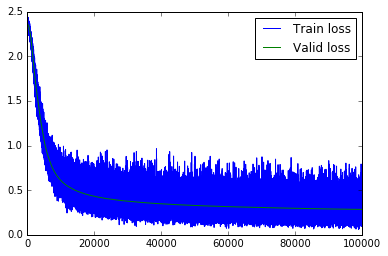

In [20]:
# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(nn.losses['train'], label='Train loss')
# plt.plot(nn.losses['smooth train'], label='Train smooth loss')
plt.plot(nn.losses['valid'], label='Valid loss')
plt.legend()
plt.show()

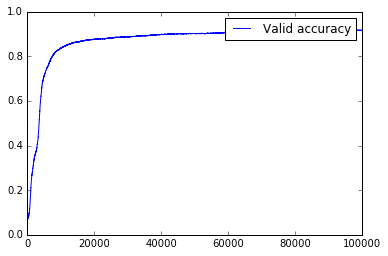

In [21]:
plt.plot(nn.losses['valid_acc'], label='Valid accuracy')
plt.legend()
plt.show()